# 1 mse loss representation -CWRU task

## 0 prepare

In [1]:
import argparse
import os
import sys
import yaml
from pprint import pprint
# 将项目根目录添加到 sys.path
project_root = '/home/lq/LQcode/2_project/PHMBench/PHM-Vibench/'
if project_root not in sys.path:
    sys.path.insert(0, project_root)
import torch
import pandas as pd
from pytorch_lightning import seed_everything

from src.utils.config_utils import load_config, path_name, transfer_namespace
from src.utils.utils import init_lab
from src.data_factory import build_data
from src.model_factory import build_model
%load_ext autoreload
%autoreload 2

/home/lq/.conda/envs/P/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!CUDA_VISIBLE_DEVICES= 1
!nvidia-smi

/bin/bash: line 1: 1: command not found
Tue Jul  1 16:16:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:41:00.0 Off |                  N/A |
| 52%   49C    P2            115W /  350W |   11009MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------

### plot——setting

In [3]:
from plot.A1_plot_config import configure_matplotlib
configure_matplotlib(style='no-latex', font_lang='en', seaborn_theme=False, font_scale=1.4)


In [4]:
# import matplotlib.font_manager
# from pprint import pprint

# # 获取 Matplotlib 字体管理器中所有已注册的字体家族名称
# # 使用 set 来确保每个字体名称只出现一次，然后排序
# font_names = sorted({
#     font.name for font in matplotlib.font_manager.fontManager.ttflist
# })

# print("Matplotlib 在您的系统上可以使用的字体家族:")
# pprint(font_names)

### data

In [5]:
# 解析命令行参数
parser = argparse.ArgumentParser(description="实验流水线")

parser.add_argument('--config_path', 
                    type=str, 
                    default='/home/lq/LQcode/2_project/PHMBench/PHM-Vibench/configs/dev/exp1_mse_lossforgeneration.yaml',
                    help='配置文件路径')
parser.add_argument('--notes', 
                    type=str, 
                    default='exp1_mse_vs_flow',
                    help='实验备注')

# 在Jupyter环境中，使用默认参数或手动设置
# args = parser.parse_args()
args = parser.parse_args(args=[]) # 使用默认值

# 执行流水线
"""
实验流水线，负责加载配置、数据和模型。
"""
# -----------------------
# 1. 加载配置文件
# -----------------------
config_path = args.config_path
print(f"[INFO] 加载配置文件: {config_path}")
configs = load_config(config_path)


# 设置环境变量和命名空间
args_environment = transfer_namespace(configs.get('environment', {}))
args_data = transfer_namespace(configs.get('data', {}))
args_model = transfer_namespace(configs.get('model', {}))
args_task = transfer_namespace(configs.get('task', {}))



# -----------------------
# 2. 准备实验环境和数据
# -----------------------
# 仅使用第一次迭代进行设置
it = 0
print(f"\n{'='*50}\n[INFO] 准备实验环境 (基于迭代 {it+1})\n{'='*50}")

# 设置路径和名称
path, name = path_name(configs, it)

# 设置随机种子
current_seed = args_environment.seed + it
seed_everything(current_seed)
print(f"[INFO] 设置随机种子: {current_seed}")

# 初始化 wandb/swanlab
# init_lab(args_environment, args, name)




    

Seed set to 42


[INFO] 加载配置文件: /home/lq/LQcode/2_project/PHMBench/PHM-Vibench/configs/dev/exp1_mse_lossforgeneration.yaml
/home/lq/LQcode/2_project/PHMBench/PHM-Vibench/dev/preexp

[INFO] 准备实验环境 (基于迭代 1)
[INFO] 设置随机种子: 42


In [6]:
# 构建数据工厂
print("[INFO] 构建数据工厂...")
data_factory = build_data(args_data, args_task)

[INFO] 构建数据工厂...
[INFO] 检查缓存文件: 数据文件已存在: /mnt/crucial/LQ/PHM-Vibench/metadata_6_11.xlsx 
[SUCCESS] 成功加载元数据，共 49867 条记录
筛选前元数据行数: 49867
筛选后元数据行数: 150
检查并准备各 Name.h5 缓存文件...


检查 Name.h5 缓存: 100%|██████████| 150/150 [00:00<00:00, 5119.13it/s]


正在将数据整合到任务缓存文件: /mnt/crucial/LQ/PHM-Vibench/cache.h5 ...


检查 cache.h5 是否已存在: 100%|██████████| 150/150 [00:00<00:00, 94070.81it/s]


数据整合完成。最终缓存文件: /mnt/crucial/LQ/PHM-Vibench/cache.h5
Using default task.
DG划分 - 使用 target_domain_num=1 进行动态划分
  - 训练域: [np.float64(0.0), np.float64(1.0), np.float64(2.0)]
  - 测试域: [np.float64(3.0)]
训练/验证样本数: 113
测试样本数: 37
Initializing training and validation datasets...


Creating train/val datasets: 100%|██████████| 113/113 [00:03<00:00, 37.14it/s]


Initializing test datasets...


Creating test datasets: 100%|██████████| 37/37 [00:00<00:00, 61.11it/s]


### model

In [7]:
# 构建模型
print("[INFO] 构建模型...")
model = build_model(args_model, metadata=data_factory.get_metadata())

print("[INFO] 模型和数据加载完成。")

[INFO] 构建模型...
成功导入模型模块: M_02_ISFM
[INFO] 模型和数据加载完成。


In [8]:
train_dataset = data_factory.get_dataset('train')
val_dataset = data_factory.get_dataset('val')
test_dataset = data_factory.get_dataset('test')

In [9]:
train_data_loader = data_factory.get_dataloader('train')
val_data_loader = data_factory.get_dataloader('val')
test_data_loader = data_factory.get_dataloader('test')

## 1 before pretraining umap

In [28]:
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

all_embeddings = []
all_labels = []

# 获取测试数据集的元数据
# 假设测试集只有一个任务/数据集，我们获取其名称和采样频率

# --- 2. 遍历数据加载器并提取特征 ---
with torch.no_grad():
    for batch in tqdm(test_data_loader, desc="提取特征中"):
        x = batch['x']
        y = batch['y']

        # 每个 batch 随机抽取2个样本
        if x.shape[0] > 2:
            indices = torch.randperm(x.shape[0])[:10]
            x_sample = x[indices]
            y_sample = y[indices]
        else:
            x_sample = x
            y_sample = y
        
        all_embeddings.append(x_sample)
        all_labels.append(y_sample)

# --- 3. 整合数据并进行 UMAP 降维 ---
# 将列表合并为大的 numpy 数组
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)





提取特征中: 100%|██████████| 148/148 [00:00<00:00, 326.91it/s]


### umap

In [27]:
print(f"UMAP 降维中，样本总数: {all_embeddings.shape[0]}...")
# 初始化并执行 UMAP
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(all_embeddings.reshape(all_embeddings.shape[0], -1))

UMAP 降维中，样本总数: 370...


/home/lq/.conda/envs/P/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lq/.conda/envs/P/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### plot

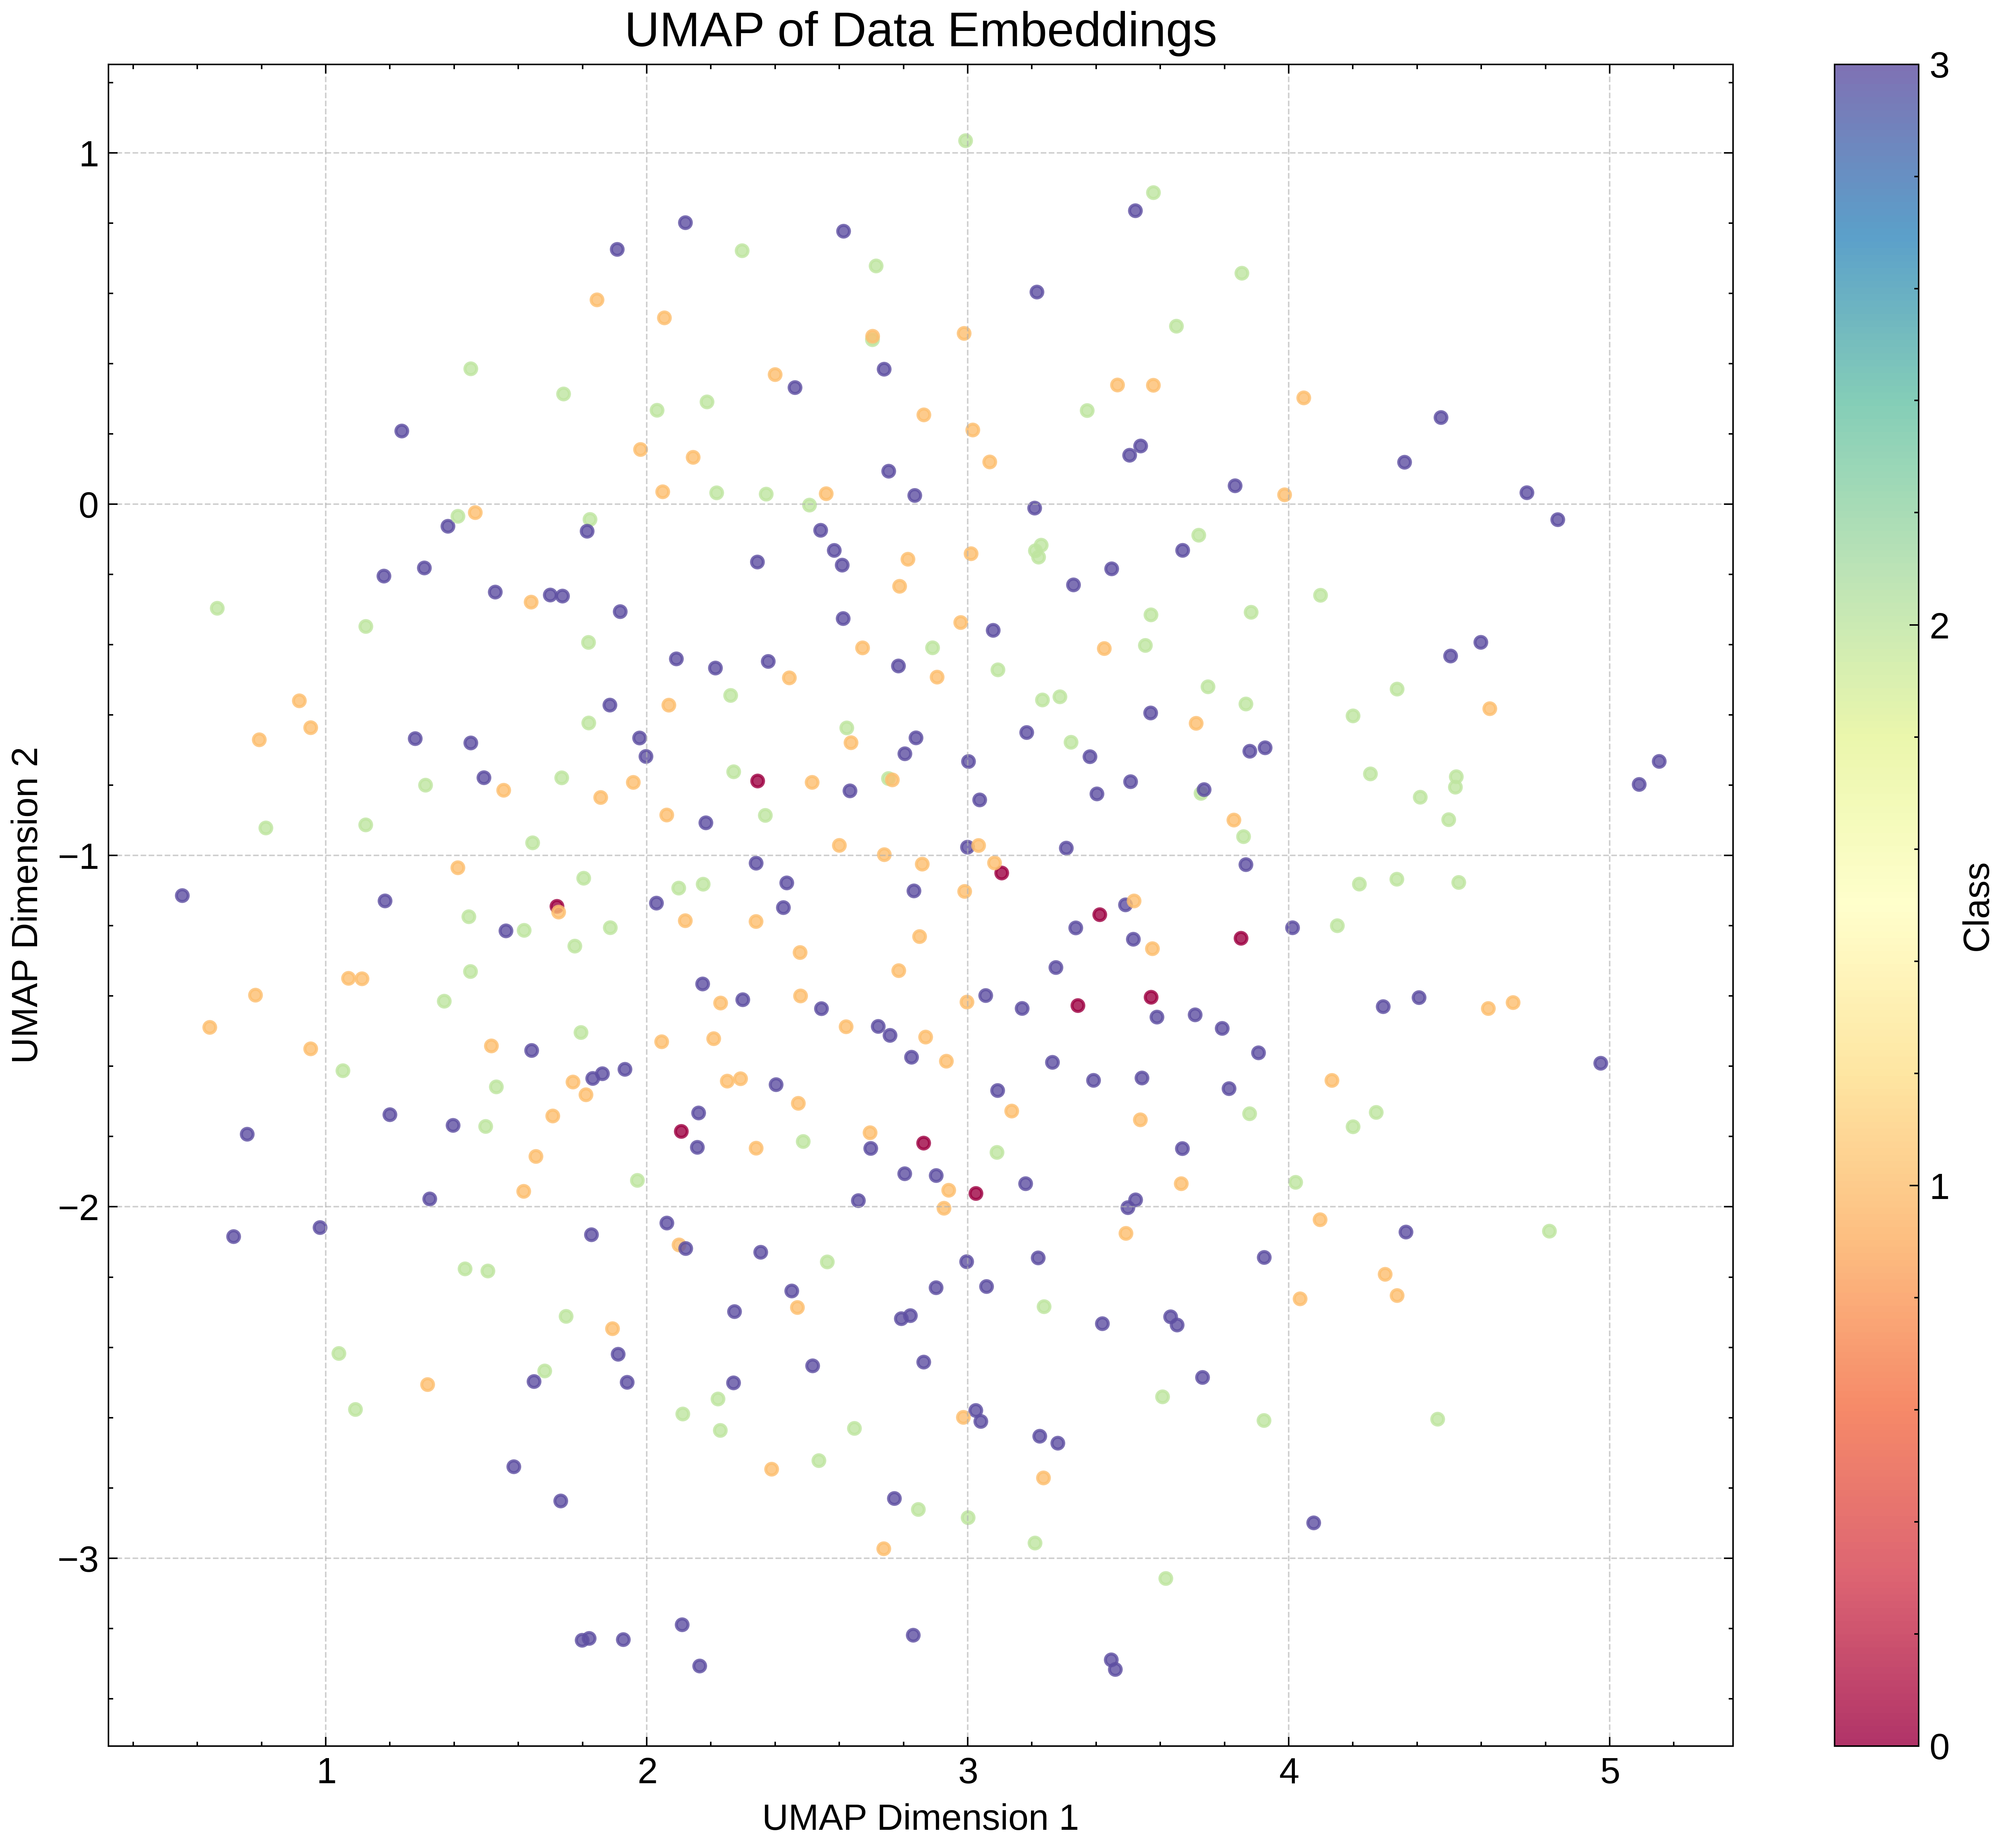

In [29]:
# --- 4. 绘制降维结果 ---
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=all_labels,
    cmap='Spectral',  # 使用 'Spectral' 或 'viridis' 等颜色映射
    s=15,             # 点的大小
    alpha=0.8         # 透明度
)

# 添加颜色条
num_classes = len(np.unique(all_labels))
cbar = plt.colorbar(scatter, ticks=np.unique(all_labels))
cbar.set_label('Class')

plt.title(f'UMAP of Data Embeddings', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('save/umap_embedding.png', dpi=300, bbox_inches='tight')  # 保存图像
plt.savefig('save/umap_embedding.pdf', dpi=300, bbox_inches='tight')  # 保存图像为 PDF
plt.show()

## 2 pretraining|MSE

### training

In [9]:
# --- 1. MSE 训练循环用于信号重构 ---
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("\n--- 开始使用 MSE Loss 进行重构训练 ---")
learning_rate = 1e-3
epochs = 10  # 为演示设置较少的训练轮数
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()  # 将模型设置为训练模式
task_id = args_task.name
for epoch in range(epochs):
    running_loss = 0.0
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x = batch['x'].to(device)
        file_id = batch['file_id'] if 'file_id' in batch else None
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播：获取重构信号 (假设模型是自编码器结构)
        reconstructed_x = model(x, file_id=file_id, task_id=task_id)  # 如果模型需要 file_id

        # 计算损失
        loss = criterion(reconstructed_x, x)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Epoch {epoch+1} 完成. 平均损失: {epoch_loss:.6f}")

print("--- 训练完成 ---")


--- 开始使用 MSE Loss 进行重构训练 ---


Epoch 1/10: 100%|██████████| 360/360 [00:06<00:00, 51.78it/s]


Epoch 1 完成. 平均损失: 0.270281


Epoch 2/10: 100%|██████████| 360/360 [00:05<00:00, 65.28it/s]


Epoch 2 完成. 平均损失: 0.109346


Epoch 3/10: 100%|██████████| 360/360 [00:05<00:00, 65.01it/s]


Epoch 3 完成. 平均损失: 0.089308


Epoch 4/10: 100%|██████████| 360/360 [00:05<00:00, 65.07it/s]


Epoch 4 完成. 平均损失: 0.079077


Epoch 5/10: 100%|██████████| 360/360 [00:05<00:00, 61.39it/s]


Epoch 5 完成. 平均损失: 0.072643


Epoch 6/10: 100%|██████████| 360/360 [00:05<00:00, 64.81it/s]


Epoch 6 完成. 平均损失: 0.068019


Epoch 7/10: 100%|██████████| 360/360 [00:05<00:00, 64.86it/s]


Epoch 7 完成. 平均损失: 0.064433


Epoch 8/10: 100%|██████████| 360/360 [00:05<00:00, 64.59it/s]


Epoch 8 完成. 平均损失: 0.061597


Epoch 9/10: 100%|██████████| 360/360 [00:05<00:00, 64.75it/s]


Epoch 9 完成. 平均损失: 0.059361


Epoch 10/10: 100%|██████████| 360/360 [00:05<00:00, 64.88it/s]

Epoch 10 完成. 平均损失: 0.057167
--- 训练完成 ---


### save mse model

In [10]:
# save model
save_path = f'save/mse_model_{task_id}.pth'
torch.save(model.state_dict(), save_path)
print(f"模型已保存到: {save_path}")

模型已保存到: save/mse_model_prediction.pth


### 重构图

In [39]:
# --- 2. 为每个类别绘制一个样本的重构图 ---
import matplotlib.pyplot as plt
import numpy as np

print("\n--- 绘制重构结果图 ---")
model.eval()  # 将模型设置为评估模式
samples_to_plot = {}
# 假设 test_dataset.labels 存在，如果不存在，需要遍历一次 test_loader 来获取
unique_labels = [0,1,2,3]
num = 1
# 从测试集中为每个类别寻找一个样本
with torch.no_grad():
    for batch in test_data_loader:
        x_batch, y_batch = batch['x'], batch['y']

        label = y_batch.to(device)[:num]
        if label not in samples_to_plot.keys():
            x = x_batch.to(device)[:num]  # 只取一个样本
            file_id = batch['file_id'][:num]
            reconstructed_tensor = model(x, file_id=file_id, task_id='prediction')
            reconstructed_tensor = reconstructed_tensor.squeeze().cpu().numpy()
            error = x.squeeze().cpu().numpy() - reconstructed_tensor
            samples_to_plot[str(label.item())] = (x, reconstructed_tensor, error)




--- 绘制重构结果图 ---


Signal length: 4096, Sampling Frequency: 12000 Hz


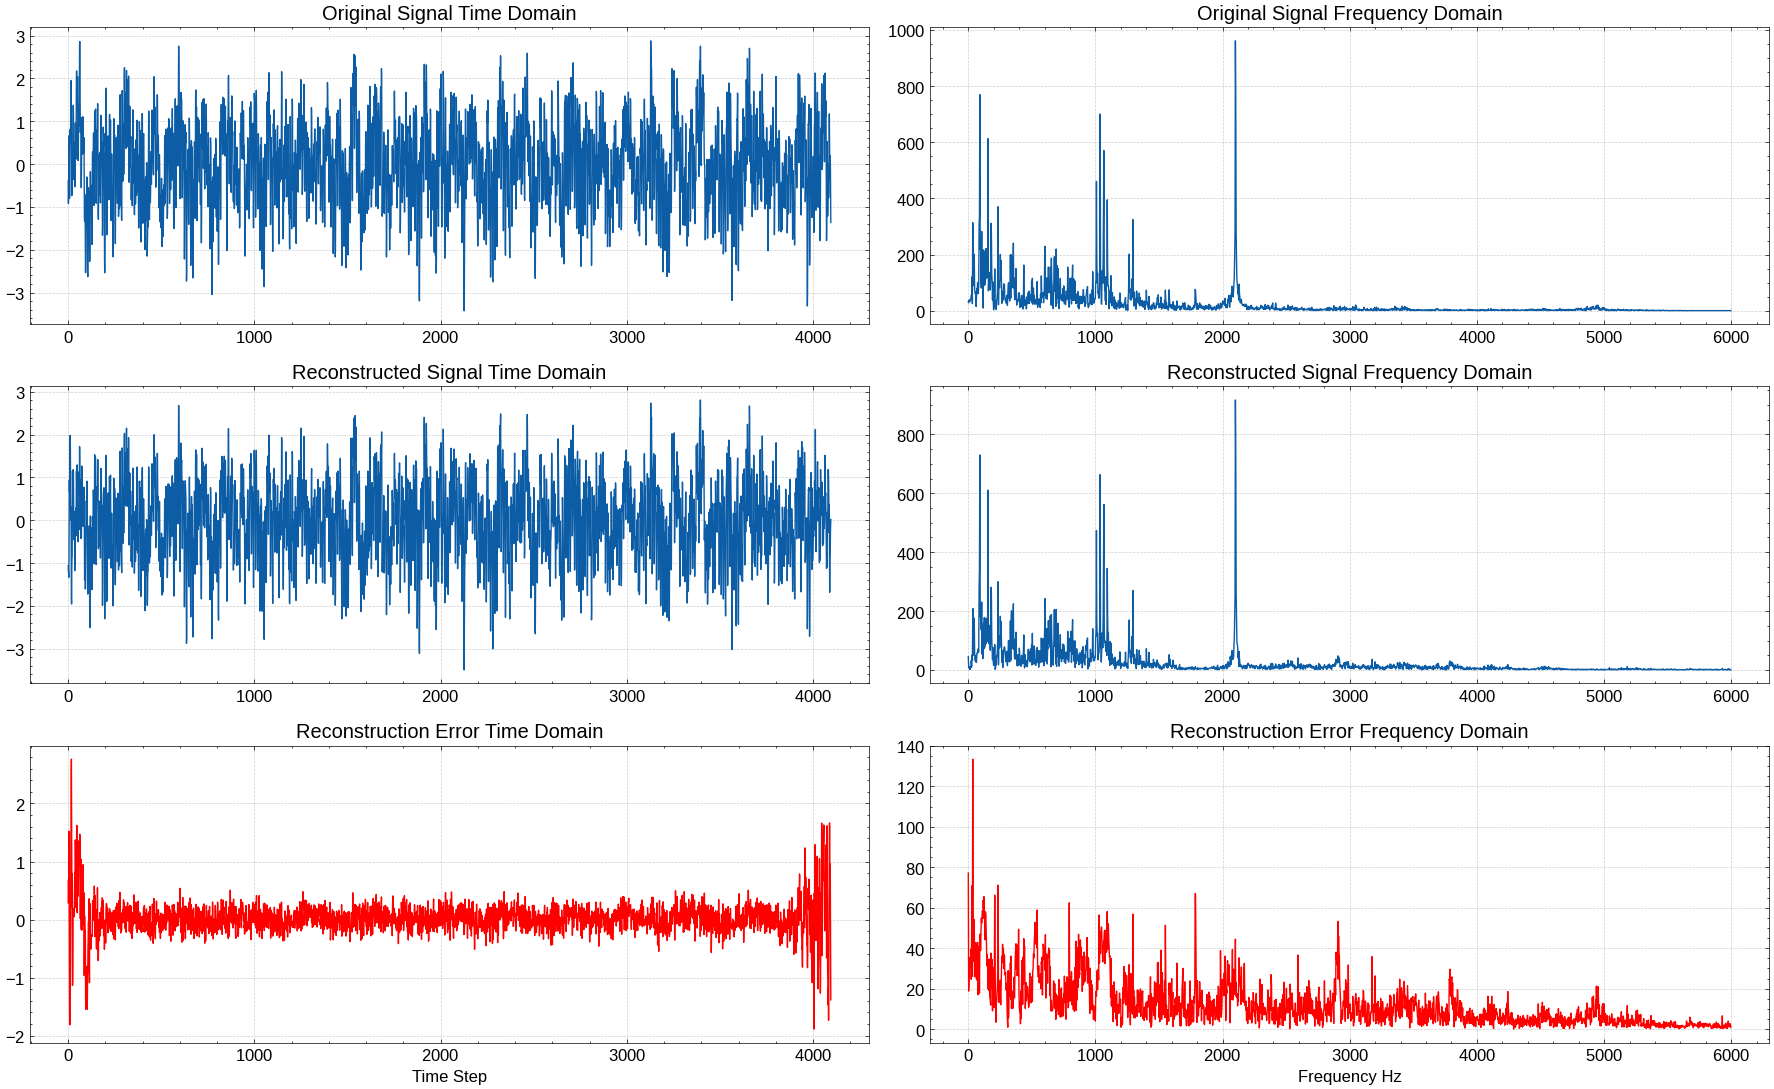

Signal length: 4096, Sampling Frequency: 12000 Hz


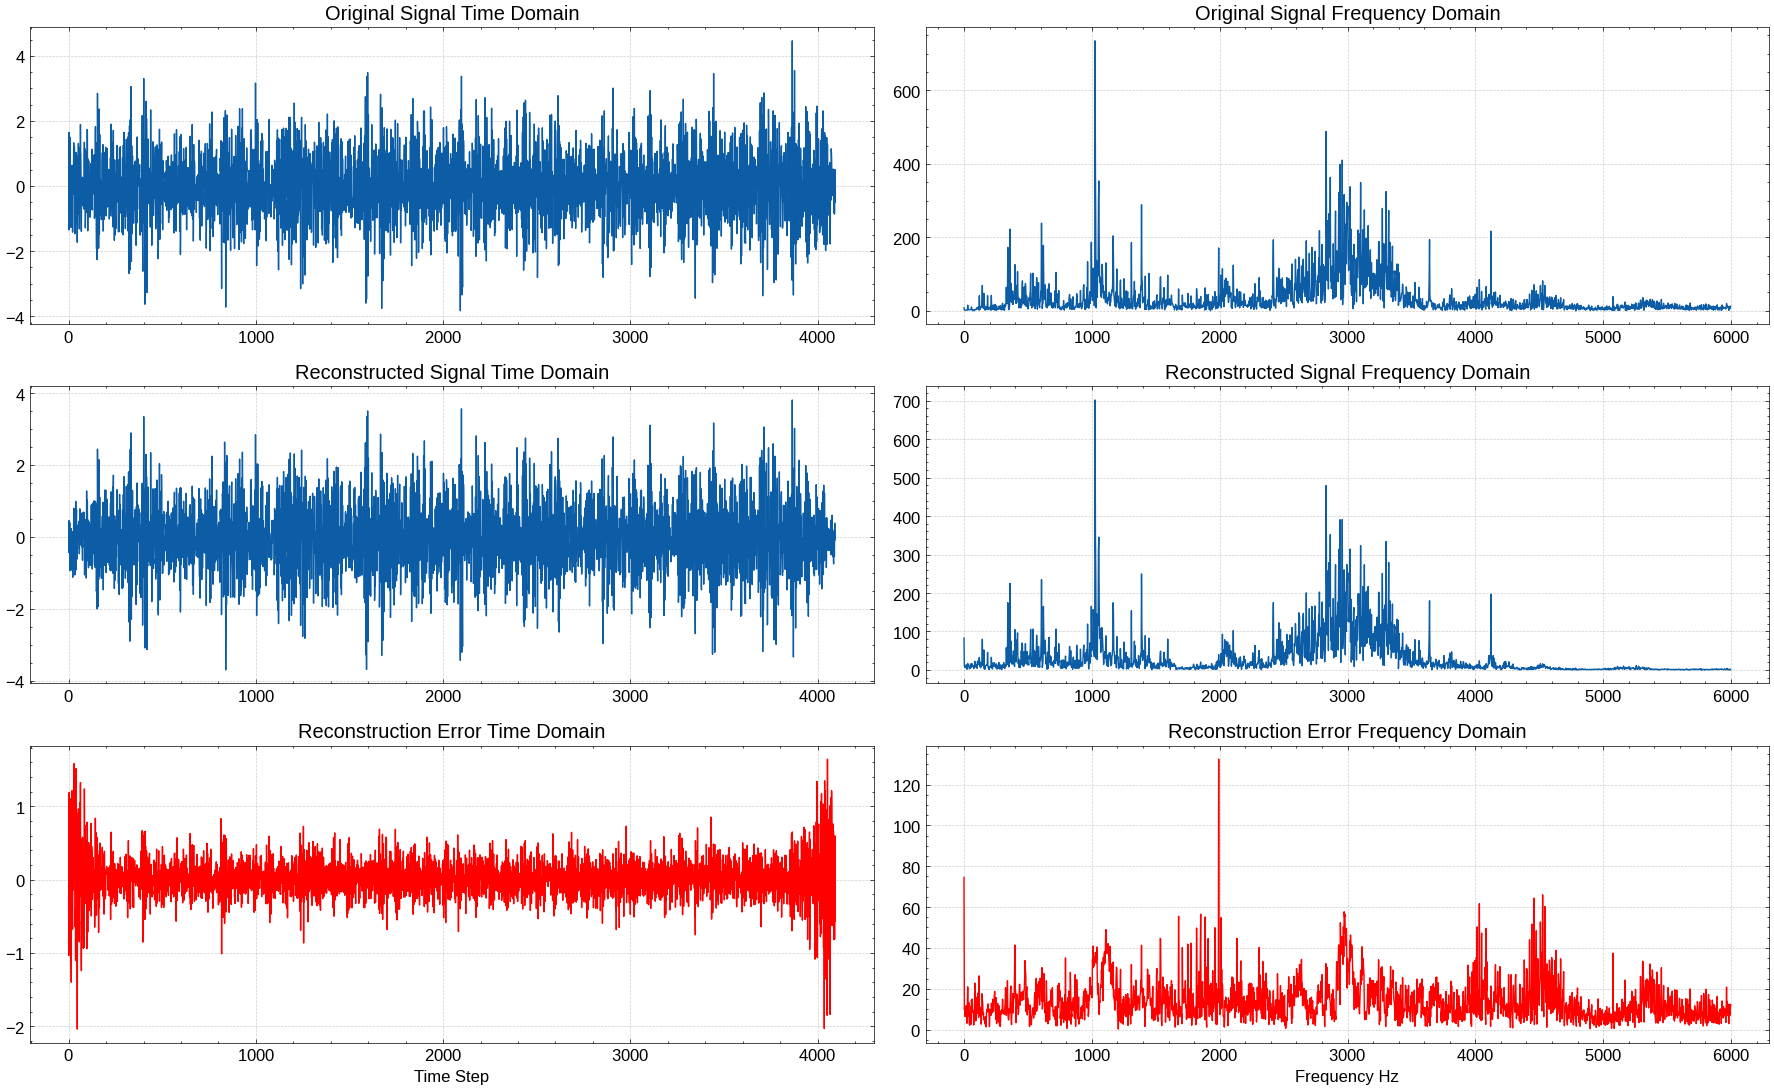

Signal length: 4096, Sampling Frequency: 12000 Hz


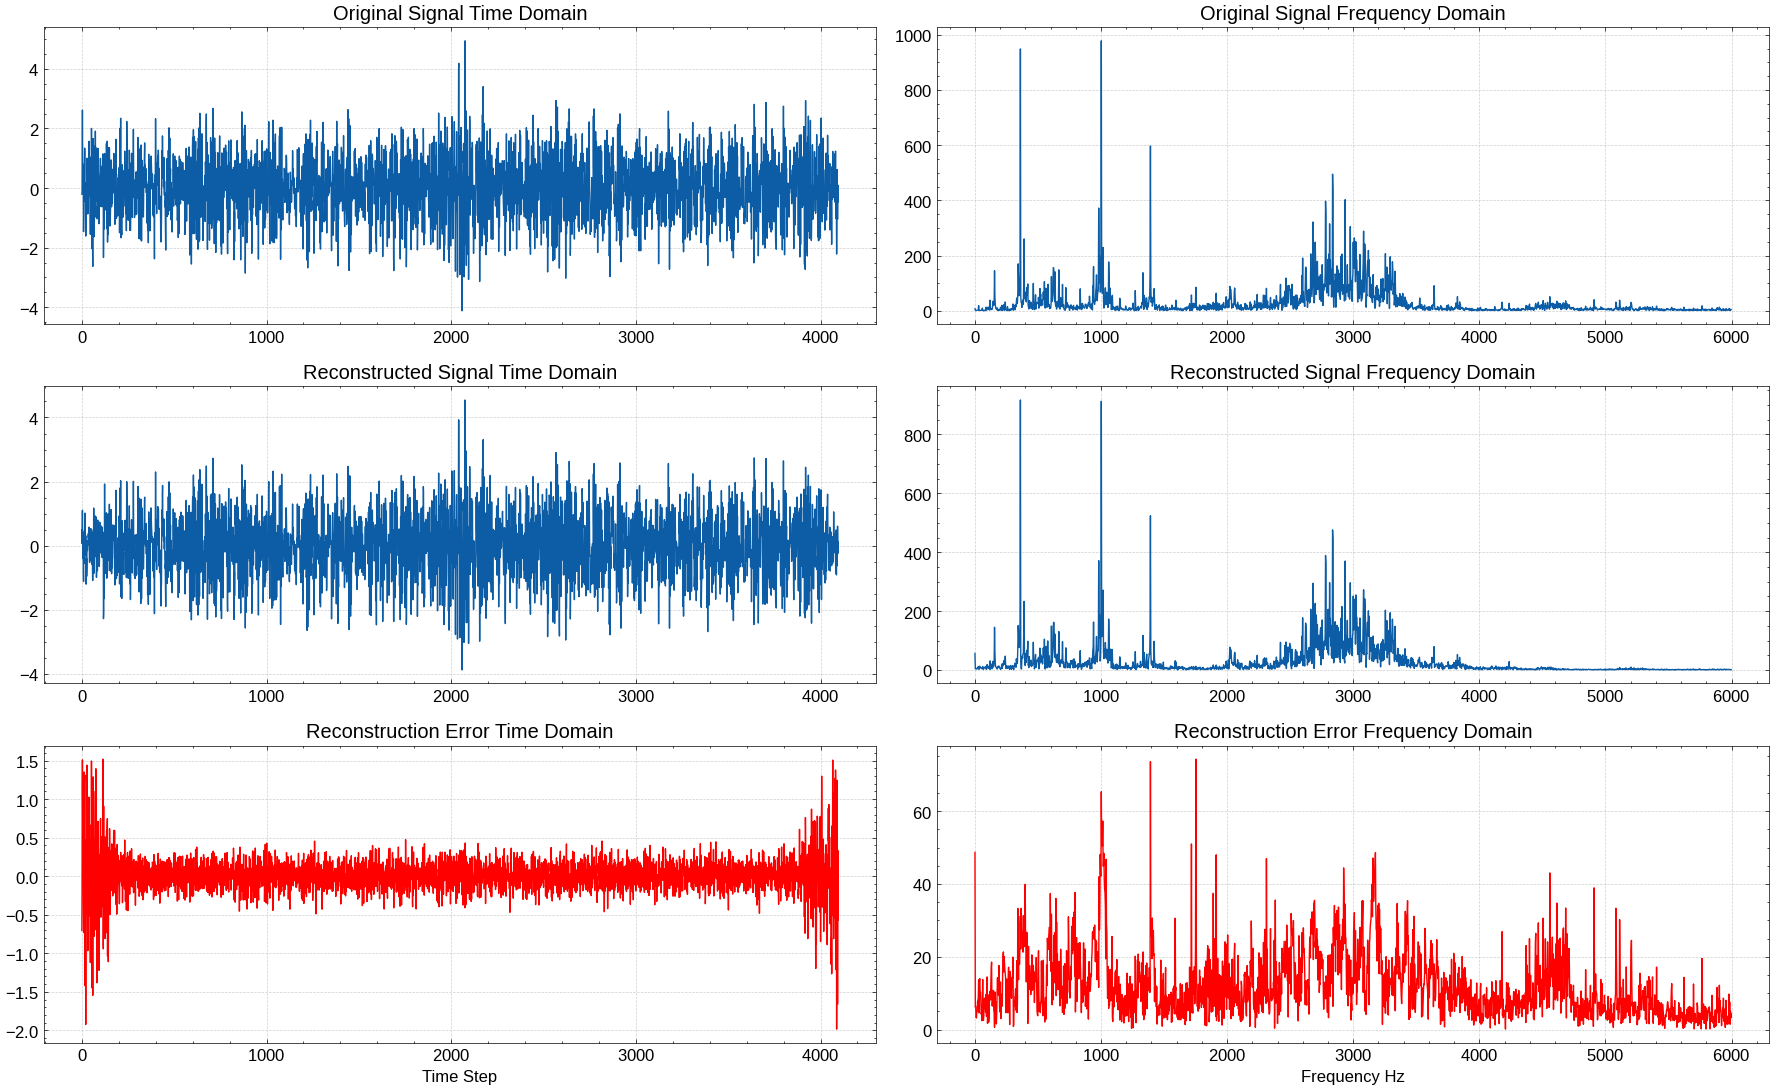

Signal length: 4096, Sampling Frequency: 12000 Hz


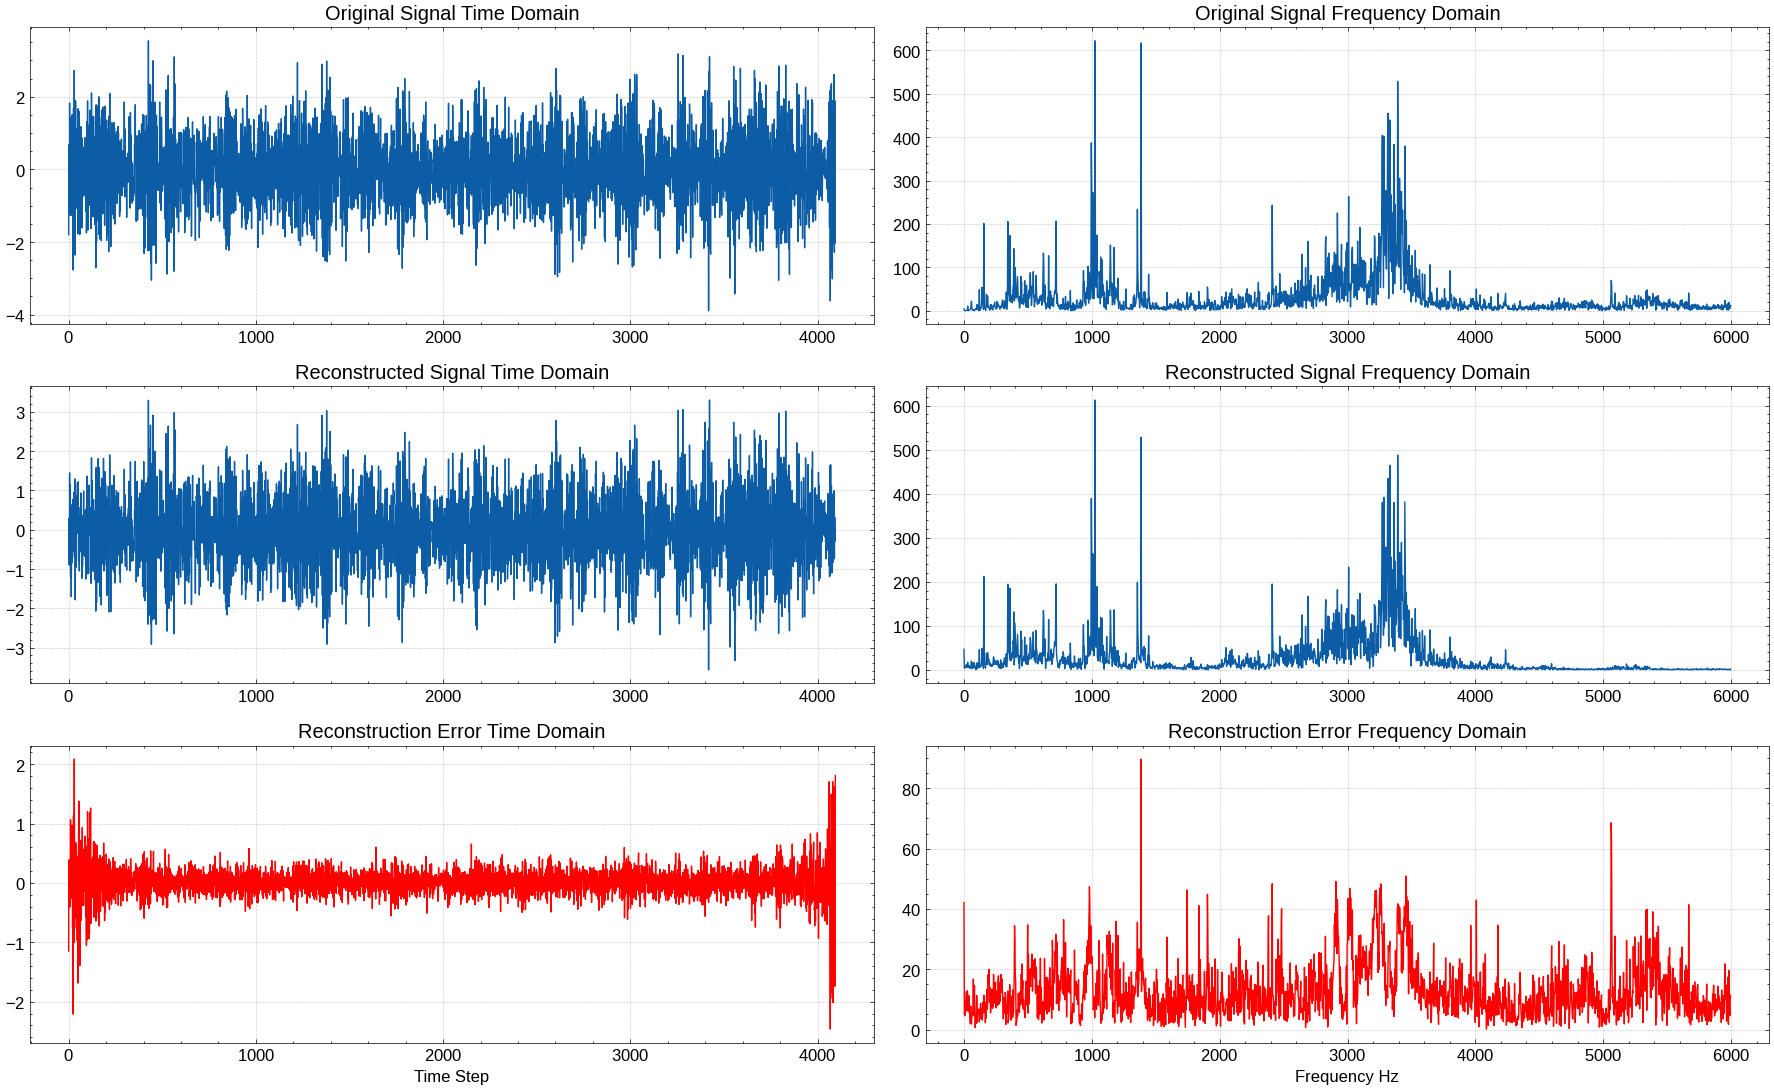

In [13]:
import numpy.fft as fft

for label, (original_tensor, reconstructed, error) in samples_to_plot.items():
    # Convert tensors to numpy arrays for plotting
    original = original_tensor.squeeze().cpu().numpy()
    
    # If the signal is multi-channel, plot only the first channel
    if original.ndim > 1:
        original = original[:,0]
        reconstructed = reconstructed[:,0]
        error = error[:,0]

    # --- Create a 3x2 subplot layout for Time and Frequency domains ---
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    # fig.suptitle(f'Signal Analysis for Class {label}', fontsize=18)
    
    # --- Column 1: Time Domain Plots ---
    # Plot Original Signal
    axes[0, 0].plot(original)
    axes[0, 0].set_title('Original Signal Time Domain')
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)
    
    # Plot Reconstructed Signal
    axes[1, 0].plot(reconstructed)
    axes[1, 0].set_title('Reconstructed Signal Time Domain')
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # Plot Reconstruction Error
    axes[2, 0].plot(error, color='red')
    axes[2, 0].set_title('Reconstruction Error Time Domain')
    axes[2, 0].set_xlabel('Time Step')
    axes[2, 0].grid(True, linestyle='--', alpha=0.6)

    # --- Column 2: Frequency Domain (FFT) Plots ---
    # !!! IMPORTANT: Set the correct sampling frequency for your dataset !!!
    # CWRU is often 12000 Hz or 48000 Hz.
    fs = 12000  # Sampling Frequency in Hz
    n = len(original)  # Signal length
    print(f"Signal length: {n}, Sampling Frequency: {fs} Hz")
    # Calculate frequency axis
    freq_axis = fft.fftfreq(n, d=1/fs)[:n//2]
    
    # Calculate FFT and magnitude
    original_fft = np.abs(fft.fft(original))[:n//2]
    reconstructed_fft = np.abs(fft.fft(reconstructed))[:n//2]
    error_fft = np.abs(fft.fft(error))[:n//2]

    # Plot Original Signal Spectrum
    axes[0, 1].plot(freq_axis, original_fft)
    axes[0, 1].set_title('Original Signal Frequency Domain')
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # Plot Reconstructed Signal Spectrum
    axes[1, 1].plot(freq_axis, reconstructed_fft)
    axes[1, 1].set_title('Reconstructed Signal Frequency Domain')
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    # Plot Error Spectrum
    axes[2, 1].plot(freq_axis, error_fft, color='red')
    axes[2, 1].set_title('Reconstruction Error Frequency Domain')
    axes[2, 1].set_xlabel('Frequency Hz')
    axes[2, 1].grid(True, linestyle='--', alpha=0.6)

    # --- Save and Show Plot ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    # Save the figure
    save_dir = 'save/reconstruction_fft'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(f'{save_dir}/analysis_class_{label}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{save_dir}/analysis_class_{label}.pdf', bbox_inches='tight')
    
    plt.show()

### hidden umap

In [18]:
num = 10
all_embeddings = []
all_labels = []
# with torch.no_grad():
    # 使用新的 debug_test_loader 进行循环
for batch in tqdm(test_data_loader, desc="提取表征中"):

    y = batch['y'][:num]  # 只取前 num 个样本
    x = batch['x'].to(device)[:num]  # 只取前 num 个样本
    file_id = batch['file_id'][:num] if 'file_id' in batch else None        
    # 使用模型的 get_rep 方法获取中间表征
    # 注意：这依赖于您的模型实现。如果方法名不同，请修改 'get_rep'
    reps = model.get_rep(x, file_id=file_id) 
    # 将表征和标签添加到列表中
    all_embeddings.append(reps.cpu().detach().numpy())
    all_labels.append(y.cpu().detach().numpy())

提取表征中:   0%|          | 0/148 [00:00<?, ?it/s]

提取表征中: 100%|██████████| 148/148 [00:00<00:00, 227.32it/s]


#### 保存 hidden

In [ ]:
# --- 3. UMAP 可视化 (后续代码不变) ---

all_reps = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [21]:


all_reps = all_reps.reshape(all_reps.shape[0], -1)  # 确保是二维数组

print(f"\nUMAP 降维中，样本总数: {all_reps.shape[0]}...")
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(all_reps)

np.save('save/mse_hidden_embedding_2d.npy', embedding_2d, allow_pickle=True)


UMAP 降维中，样本总数: 1480...


/home/lq/.conda/envs/P/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lq/.conda/envs/P/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


#### plot

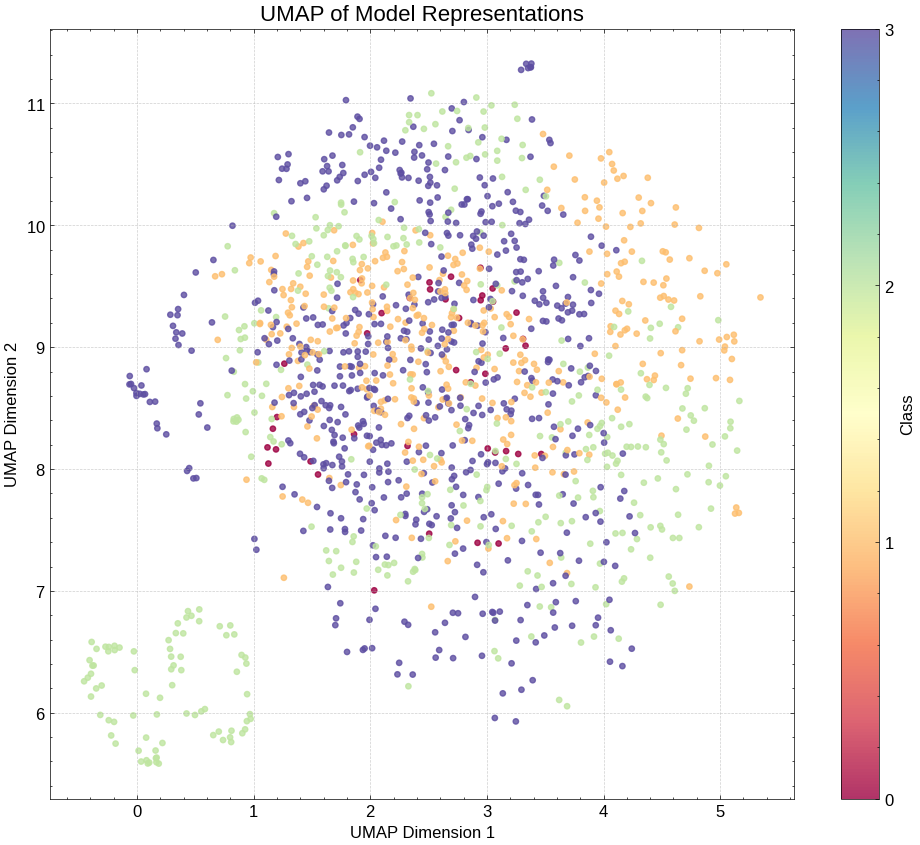

In [22]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=all_labels,
    cmap='Spectral',
    s=15,
    alpha=0.8
)
cbar = plt.colorbar(scatter, ticks=np.unique(all_labels))
cbar.set_label('Class')
plt.title('UMAP of Model Representations', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True, linestyle='--', alpha=0.6)

save_dir = 'save/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(f'{save_dir}/umap_mse_rep.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{save_dir}/umap_mse_rep.pdf', bbox_inches='tight')

plt.show()

## 3 pretraining | masked prediction

#### init model

In [16]:
# 构建模型
print("[INFO] 构建模型...")
model_masked_prediction = build_model(args_model, metadata=data_factory.get_metadata())

print("[INFO] 模型和数据加载完成。")

[INFO] 构建模型...
成功导入模型模块: M_02_ISFM
[INFO] 模型和数据加载完成。


#### mask_prediction loss

In [ ]:
args_task.mask_ratio = 0.5
args_task.forecast_part = 0.5
args_task

In [11]:
# --- 2. MSE 训练循环用于信号重构 ---
from src.task_factory.Components.prediction_loss import Signal_mask_Loss
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_masked_prediction = model# .copy()  # 复制模型结构
model_masked_prediction.to(device)
print("\n--- 开始使用 MSE Loss 进行重构训练 ---")
learning_rate = 1e-3
epochs = 100  # 为演示设置较少的训练轮数
criterion = Signal_mask_Loss(args_task)
optimizer = optim.Adam(model_masked_prediction.parameters(), lr=learning_rate)
model_masked_prediction.train()  # 将模型设置为训练模式
task_id = args_task.name
for epoch in range(epochs):
    running_loss = 0.0
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # x = batch['x'].to(device)
        # file_id = batch['file_id'] if 'file_id' in batch else None
        batch['x'] = batch['x'].to(device)
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播：获取重构信号 (假设模型是自编码器结构)
        # reconstructed_x = model(x, file_id=file_id, task_id=task_id)  # 如果模型需要 file_id
        
        # 计算损失
        loss = criterion(model_masked_prediction, batch)

        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Epoch {epoch+1} 完成. 平均损失: {epoch_loss:.6f}")

print("--- 训练完成 ---")


--- 开始使用 MSE Loss 进行重构训练 ---


Epoch 1/100: 100%|██████████| 360/360 [00:07<00:00, 49.68it/s]


Epoch 1 完成. 平均损失: 0.879268


Epoch 2/100: 100%|██████████| 360/360 [00:05<00:00, 61.82it/s]


Epoch 2 完成. 平均损失: 0.822300


Epoch 3/100: 100%|██████████| 360/360 [00:05<00:00, 61.63it/s]


Epoch 3 完成. 平均损失: 0.806957


Epoch 4/100: 100%|██████████| 360/360 [00:05<00:00, 60.67it/s]


Epoch 4 完成. 平均损失: 0.799769


Epoch 5/100: 100%|██████████| 360/360 [00:05<00:00, 60.92it/s]


Epoch 5 完成. 平均损失: 0.795051


Epoch 6/100: 100%|██████████| 360/360 [00:05<00:00, 61.35it/s]


Epoch 6 完成. 平均损失: 0.791678


Epoch 7/100: 100%|██████████| 360/360 [00:05<00:00, 60.86it/s]


Epoch 7 完成. 平均损失: 0.789421


Epoch 8/100: 100%|██████████| 360/360 [00:05<00:00, 60.54it/s]


Epoch 8 完成. 平均损失: 0.787163


Epoch 9/100: 100%|██████████| 360/360 [00:05<00:00, 60.61it/s]


Epoch 9 完成. 平均损失: 0.785560


Epoch 10/100: 100%|██████████| 360/360 [00:05<00:00, 60.49it/s]


Epoch 10 完成. 平均损失: 0.783572


Epoch 11/100: 100%|██████████| 360/360 [00:05<00:00, 60.87it/s]


Epoch 11 完成. 平均损失: 0.782023


Epoch 12/100: 100%|██████████| 360/360 [00:05<00:00, 60.91it/s]


Epoch 12 完成. 平均损失: 0.780622


Epoch 13/100: 100%|██████████| 360/360 [00:05<00:00, 60.27it/s]


Epoch 13 完成. 平均损失: 0.778980


Epoch 14/100: 100%|██████████| 360/360 [00:05<00:00, 60.77it/s]


Epoch 14 完成. 平均损失: 0.777683


Epoch 15/100: 100%|██████████| 360/360 [00:05<00:00, 61.65it/s]


Epoch 15 完成. 平均损失: 0.776394


Epoch 16/100: 100%|██████████| 360/360 [00:05<00:00, 61.17it/s]


Epoch 16 完成. 平均损失: 0.775540


Epoch 17/100: 100%|██████████| 360/360 [00:05<00:00, 61.18it/s]


Epoch 17 完成. 平均损失: 0.773805


Epoch 18/100: 100%|██████████| 360/360 [00:05<00:00, 61.40it/s]


Epoch 18 完成. 平均损失: 0.772956


Epoch 19/100: 100%|██████████| 360/360 [00:05<00:00, 61.21it/s]


Epoch 19 完成. 平均损失: 0.771815


Epoch 20/100: 100%|██████████| 360/360 [00:05<00:00, 60.98it/s]


Epoch 20 完成. 平均损失: 0.770778


Epoch 21/100: 100%|██████████| 360/360 [00:05<00:00, 61.55it/s]


Epoch 21 完成. 平均损失: 0.769793


Epoch 22/100: 100%|██████████| 360/360 [00:05<00:00, 60.99it/s]


Epoch 22 完成. 平均损失: 0.769044


Epoch 23/100: 100%|██████████| 360/360 [00:05<00:00, 60.55it/s]


Epoch 23 完成. 平均损失: 0.768454


Epoch 24/100: 100%|██████████| 360/360 [00:05<00:00, 61.21it/s]


Epoch 24 完成. 平均损失: 0.767608


Epoch 25/100: 100%|██████████| 360/360 [00:05<00:00, 61.33it/s]


Epoch 25 完成. 平均损失: 0.766952


Epoch 26/100: 100%|██████████| 360/360 [00:05<00:00, 60.61it/s]


Epoch 26 完成. 平均损失: 0.766414


Epoch 27/100: 100%|██████████| 360/360 [00:05<00:00, 60.96it/s]


Epoch 27 完成. 平均损失: 0.765644


Epoch 28/100: 100%|██████████| 360/360 [00:05<00:00, 60.89it/s]


Epoch 28 完成. 平均损失: 0.765316


Epoch 29/100: 100%|██████████| 360/360 [00:05<00:00, 61.20it/s]


Epoch 29 完成. 平均损失: 0.764704


Epoch 30/100: 100%|██████████| 360/360 [00:05<00:00, 60.98it/s]


Epoch 30 完成. 平均损失: 0.764129


Epoch 31/100: 100%|██████████| 360/360 [00:05<00:00, 61.37it/s]


Epoch 31 完成. 平均损失: 0.763611


Epoch 32/100: 100%|██████████| 360/360 [00:05<00:00, 61.16it/s]


Epoch 32 完成. 平均损失: 0.763603


Epoch 33/100: 100%|██████████| 360/360 [00:05<00:00, 61.33it/s]


Epoch 33 完成. 平均损失: 0.762811


Epoch 34/100: 100%|██████████| 360/360 [00:05<00:00, 61.09it/s]


Epoch 34 完成. 平均损失: 0.762464


Epoch 35/100: 100%|██████████| 360/360 [00:05<00:00, 61.40it/s]


Epoch 35 完成. 平均损失: 0.762075


Epoch 36/100: 100%|██████████| 360/360 [00:05<00:00, 60.57it/s]


Epoch 36 完成. 平均损失: 0.761583


Epoch 37/100: 100%|██████████| 360/360 [00:05<00:00, 60.30it/s]


Epoch 37 完成. 平均损失: 0.761162


Epoch 38/100: 100%|██████████| 360/360 [00:05<00:00, 60.61it/s]


Epoch 38 完成. 平均损失: 0.761168


Epoch 39/100: 100%|██████████| 360/360 [00:05<00:00, 60.23it/s]


Epoch 39 完成. 平均损失: 0.760836


Epoch 40/100: 100%|██████████| 360/360 [00:05<00:00, 60.38it/s]


Epoch 40 完成. 平均损失: 0.760654


Epoch 41/100: 100%|██████████| 360/360 [00:05<00:00, 60.44it/s]


Epoch 41 完成. 平均损失: 0.760009


Epoch 42/100: 100%|██████████| 360/360 [00:05<00:00, 60.42it/s]


Epoch 42 完成. 平均损失: 0.759772


Epoch 43/100: 100%|██████████| 360/360 [00:05<00:00, 61.13it/s]


Epoch 43 完成. 平均损失: 0.759604


Epoch 44/100: 100%|██████████| 360/360 [00:05<00:00, 60.66it/s]


Epoch 44 完成. 平均损失: 0.759210


Epoch 45/100: 100%|██████████| 360/360 [00:06<00:00, 59.68it/s]


Epoch 45 完成. 平均损失: 0.758784


Epoch 46/100: 100%|██████████| 360/360 [00:05<00:00, 60.50it/s]


Epoch 46 完成. 平均损失: 0.758635


Epoch 47/100: 100%|██████████| 360/360 [00:05<00:00, 60.79it/s]


Epoch 47 完成. 平均损失: 0.758341


Epoch 48/100: 100%|██████████| 360/360 [00:05<00:00, 60.25it/s]


Epoch 48 完成. 平均损失: 0.758048


Epoch 49/100: 100%|██████████| 360/360 [00:05<00:00, 60.45it/s]


Epoch 49 完成. 平均损失: 0.757967


Epoch 50/100: 100%|██████████| 360/360 [00:05<00:00, 61.01it/s]


Epoch 50 完成. 平均损失: 0.757710


Epoch 51/100: 100%|██████████| 360/360 [00:06<00:00, 59.81it/s]


Epoch 51 完成. 平均损失: 0.757493


Epoch 52/100: 100%|██████████| 360/360 [00:05<00:00, 60.81it/s]


Epoch 52 完成. 平均损失: 0.757281


Epoch 53/100: 100%|██████████| 360/360 [00:05<00:00, 61.29it/s]


Epoch 53 完成. 平均损失: 0.756858


Epoch 54/100: 100%|██████████| 360/360 [00:06<00:00, 59.77it/s]


Epoch 54 完成. 平均损失: 0.756734


Epoch 55/100: 100%|██████████| 360/360 [00:05<00:00, 60.26it/s]


Epoch 55 完成. 平均损失: 0.756539


Epoch 56/100: 100%|██████████| 360/360 [00:05<00:00, 60.85it/s]


Epoch 56 完成. 平均损失: 0.754236


Epoch 57/100: 100%|██████████| 360/360 [00:05<00:00, 60.36it/s]


Epoch 57 完成. 平均损失: 0.752150


Epoch 58/100: 100%|██████████| 360/360 [00:05<00:00, 60.55it/s]


Epoch 58 完成. 平均损失: 0.751286


Epoch 59/100: 100%|██████████| 360/360 [00:05<00:00, 60.29it/s]


Epoch 59 完成. 平均损失: 0.750629


Epoch 60/100: 100%|██████████| 360/360 [00:05<00:00, 61.35it/s]


Epoch 60 完成. 平均损失: 0.750004


Epoch 61/100: 100%|██████████| 360/360 [00:05<00:00, 61.42it/s]


Epoch 61 完成. 平均损失: 0.749365


Epoch 62/100: 100%|██████████| 360/360 [00:05<00:00, 61.24it/s]


Epoch 62 完成. 平均损失: 0.748799


Epoch 63/100: 100%|██████████| 360/360 [00:05<00:00, 60.70it/s]


Epoch 63 完成. 平均损失: 0.748440


Epoch 64/100: 100%|██████████| 360/360 [00:05<00:00, 60.19it/s]


Epoch 64 完成. 平均损失: 0.747840


Epoch 65/100: 100%|██████████| 360/360 [00:06<00:00, 59.95it/s]


Epoch 65 完成. 平均损失: 0.747696


Epoch 66/100: 100%|██████████| 360/360 [00:05<00:00, 60.40it/s]


Epoch 66 完成. 平均损失: 0.747314


Epoch 67/100: 100%|██████████| 360/360 [00:05<00:00, 60.91it/s]


Epoch 67 完成. 平均损失: 0.746849


Epoch 68/100: 100%|██████████| 360/360 [00:05<00:00, 61.41it/s]


Epoch 68 完成. 平均损失: 0.746588


Epoch 69/100: 100%|██████████| 360/360 [00:05<00:00, 61.31it/s]


Epoch 69 完成. 平均损失: 0.746206


Epoch 70/100: 100%|██████████| 360/360 [00:05<00:00, 61.41it/s]


Epoch 70 完成. 平均损失: 0.746005


Epoch 71/100: 100%|██████████| 360/360 [00:05<00:00, 60.97it/s]


Epoch 71 完成. 平均损失: 0.745449


Epoch 72/100: 100%|██████████| 360/360 [00:05<00:00, 61.15it/s]


Epoch 72 完成. 平均损失: 0.745377


Epoch 73/100: 100%|██████████| 360/360 [00:05<00:00, 61.62it/s]


Epoch 73 完成. 平均损失: 0.745036


Epoch 74/100: 100%|██████████| 360/360 [00:05<00:00, 61.42it/s]


Epoch 74 完成. 平均损失: 0.744600


Epoch 75/100: 100%|██████████| 360/360 [00:05<00:00, 61.00it/s]


Epoch 75 完成. 平均损失: 0.743867


Epoch 76/100: 100%|██████████| 360/360 [00:05<00:00, 60.51it/s]


Epoch 76 完成. 平均损失: 0.742638


Epoch 77/100: 100%|██████████| 360/360 [00:05<00:00, 60.83it/s]


Epoch 77 完成. 平均损失: 0.739990


Epoch 78/100: 100%|██████████| 360/360 [00:05<00:00, 61.22it/s]


Epoch 78 完成. 平均损失: 0.735910


Epoch 79/100: 100%|██████████| 360/360 [00:05<00:00, 60.75it/s]


Epoch 79 完成. 平均损失: 0.731276


Epoch 80/100: 100%|██████████| 360/360 [00:05<00:00, 61.39it/s]


Epoch 80 完成. 平均损失: 0.728169


Epoch 81/100: 100%|██████████| 360/360 [00:05<00:00, 60.92it/s]


Epoch 81 完成. 平均损失: 0.725640


Epoch 82/100: 100%|██████████| 360/360 [00:05<00:00, 61.38it/s]


Epoch 82 完成. 平均损失: 0.722922


Epoch 83/100: 100%|██████████| 360/360 [00:05<00:00, 61.26it/s]


Epoch 83 完成. 平均损失: 0.721199


Epoch 84/100: 100%|██████████| 360/360 [00:05<00:00, 61.20it/s]


Epoch 84 完成. 平均损失: 0.719477


Epoch 85/100: 100%|██████████| 360/360 [00:05<00:00, 61.11it/s]


Epoch 85 完成. 平均损失: 0.717883


Epoch 86/100: 100%|██████████| 360/360 [00:05<00:00, 61.40it/s]


Epoch 86 完成. 平均损失: 0.716681


Epoch 87/100: 100%|██████████| 360/360 [00:05<00:00, 61.05it/s]


Epoch 87 完成. 平均损失: 0.715533


Epoch 88/100: 100%|██████████| 360/360 [00:05<00:00, 60.85it/s]


Epoch 88 完成. 平均损失: 0.714807


Epoch 89/100: 100%|██████████| 360/360 [00:05<00:00, 60.47it/s]


Epoch 89 完成. 平均损失: 0.713614


Epoch 90/100: 100%|██████████| 360/360 [00:05<00:00, 60.74it/s]


Epoch 90 完成. 平均损失: 0.712784


Epoch 91/100: 100%|██████████| 360/360 [00:05<00:00, 60.02it/s]


Epoch 91 完成. 平均损失: 0.712276


Epoch 92/100: 100%|██████████| 360/360 [00:05<00:00, 60.46it/s]


Epoch 92 完成. 平均损失: 0.711557


Epoch 93/100: 100%|██████████| 360/360 [00:05<00:00, 60.25it/s]


Epoch 93 完成. 平均损失: 0.710881


Epoch 94/100: 100%|██████████| 360/360 [00:05<00:00, 60.85it/s]


Epoch 94 完成. 平均损失: 0.710376


Epoch 95/100: 100%|██████████| 360/360 [00:05<00:00, 60.90it/s]


Epoch 95 完成. 平均损失: 0.709834


Epoch 96/100: 100%|██████████| 360/360 [00:05<00:00, 60.85it/s]


Epoch 96 完成. 平均损失: 0.709171


Epoch 97/100: 100%|██████████| 360/360 [00:05<00:00, 61.04it/s]


Epoch 97 完成. 平均损失: 0.708916


Epoch 98/100: 100%|██████████| 360/360 [00:05<00:00, 60.79it/s]


Epoch 98 完成. 平均损失: 0.708106


Epoch 99/100: 100%|██████████| 360/360 [00:05<00:00, 60.12it/s]


Epoch 99 完成. 平均损失: 0.707925


Epoch 100/100: 100%|██████████| 360/360 [00:05<00:00, 61.15it/s]

Epoch 100 完成. 平均损失: 0.707267
--- 训练完成 ---


#### prediction model save

In [15]:
# save_path = f'save/mse_model_{task_id}.pth'
save_path = f'save/masked_prediction_model_{task_id}_100epoch.pth'
torch.save(model_masked_prediction.state_dict(), save_path)
print(f"模型已保存到: {save_path}")

模型已保存到: save/masked_prediction_model_prediction_100epoch.pth


#### 重构图

In [13]:
# --- 2. 为每个类别绘制一个样本的重构图 ---
import matplotlib.pyplot as plt
import numpy as np

print("\n--- 绘制重构结果图 ---")
model.eval()  # 将模型设置为评估模式
samples_to_plot = {}
# 假设 test_dataset.labels 存在，如果不存在，需要遍历一次 test_loader 来获取
unique_labels = [0,1,2,3]
num = 1
# 从测试集中为每个类别寻找一个样本
with torch.no_grad():
    for batch in test_data_loader:
        x_batch, y_batch = batch['x'], batch['y']

        label = y_batch.to(device)[:num]
        if label not in samples_to_plot.keys():
            x = x_batch.to(device)[:num]  # 只取一个样本
            file_id = batch['file_id'][:num]
            reconstructed_tensor = model(x, file_id=file_id, task_id='prediction')
            reconstructed_tensor = reconstructed_tensor.squeeze().cpu().numpy()
            error = x.squeeze().cpu().numpy() - reconstructed_tensor
            samples_to_plot[str(label.item())] = (x, reconstructed_tensor, error)




--- 绘制重构结果图 ---


Signal length: 4096, Sampling Frequency: 12000 Hz


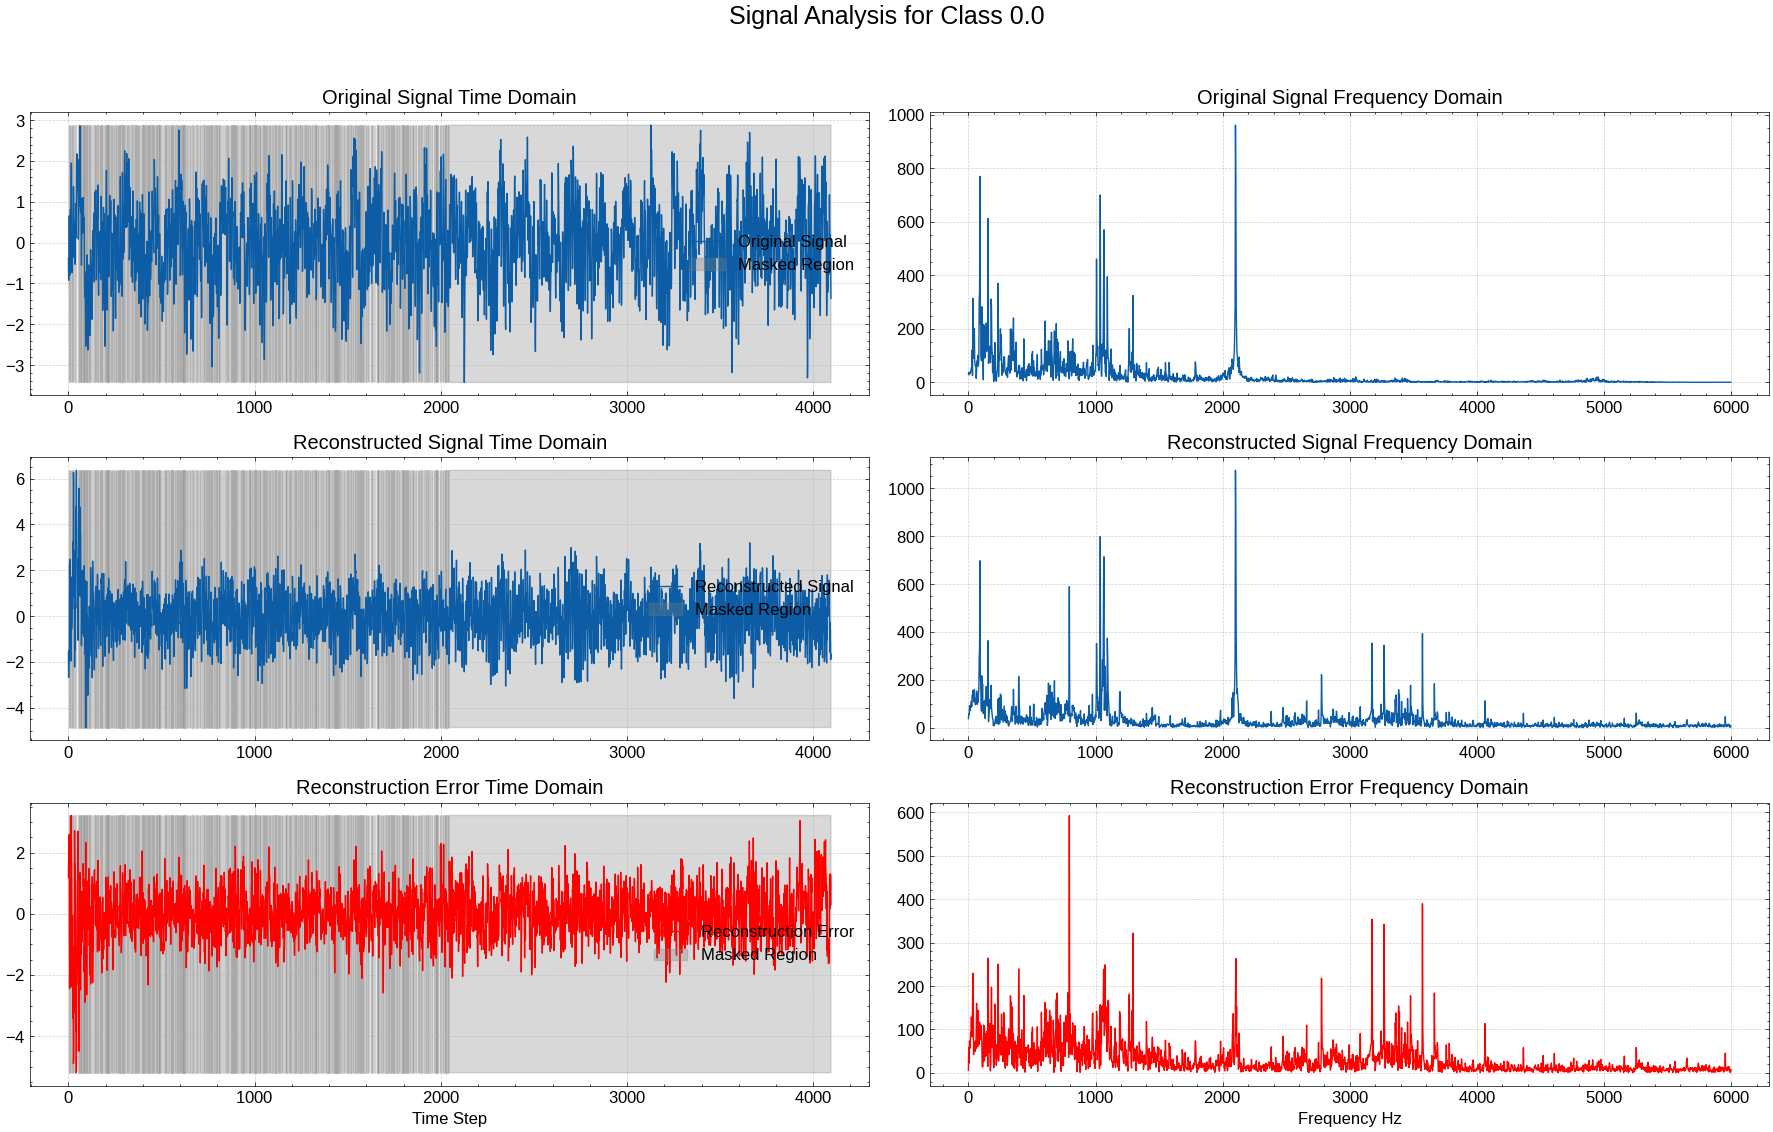

Signal length: 4096, Sampling Frequency: 12000 Hz


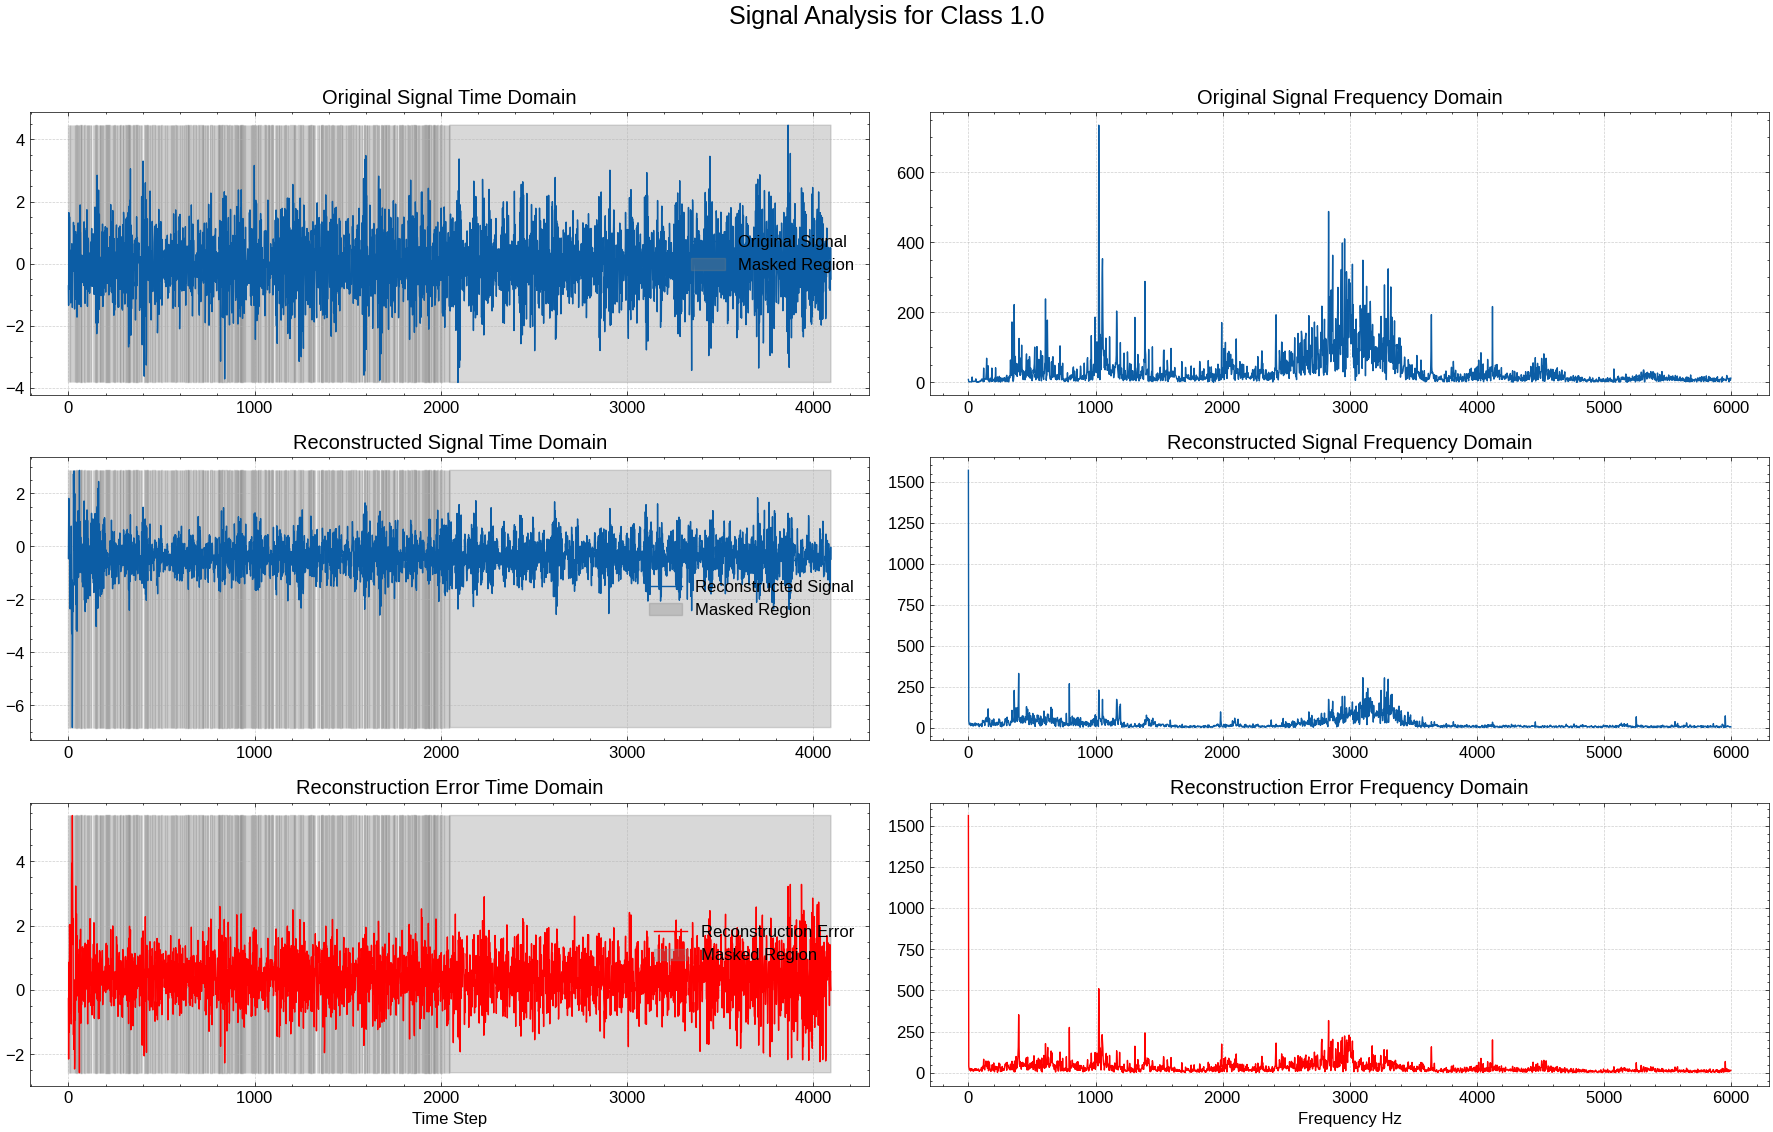

Signal length: 4096, Sampling Frequency: 12000 Hz


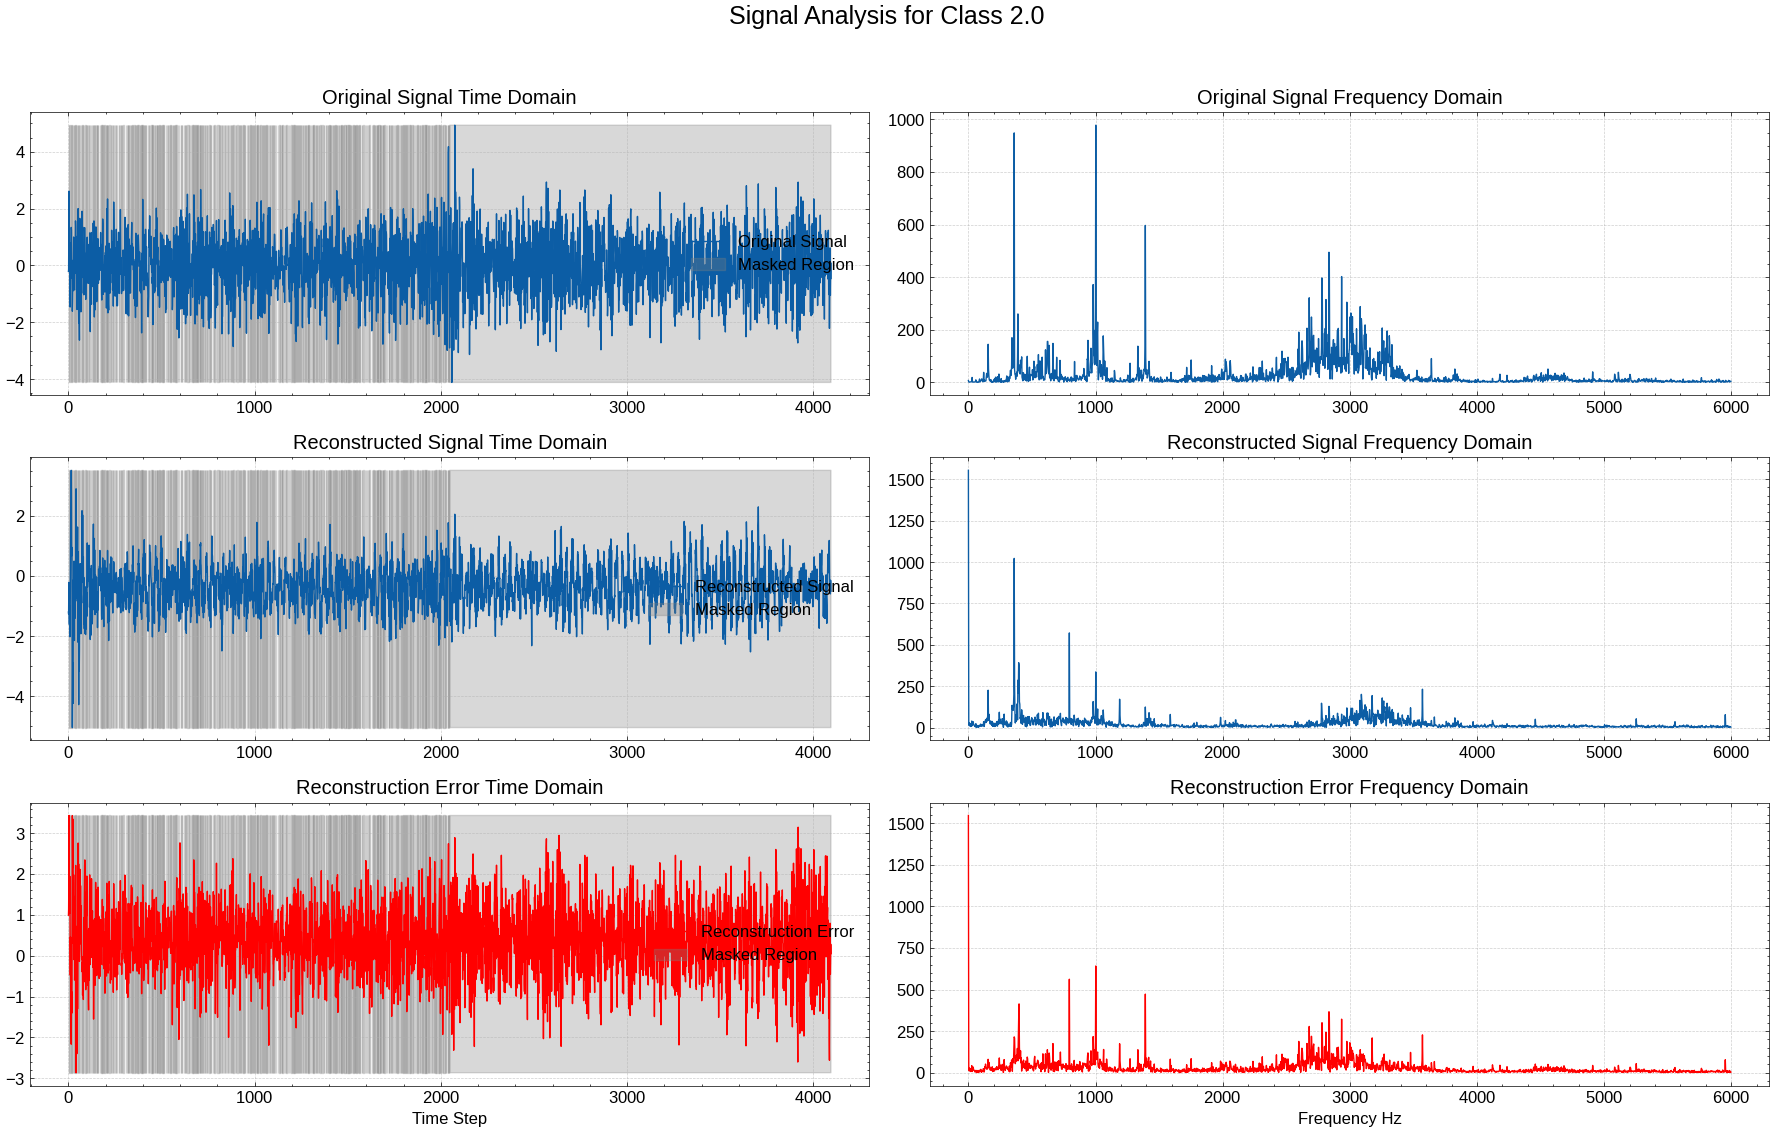

Signal length: 4096, Sampling Frequency: 12000 Hz


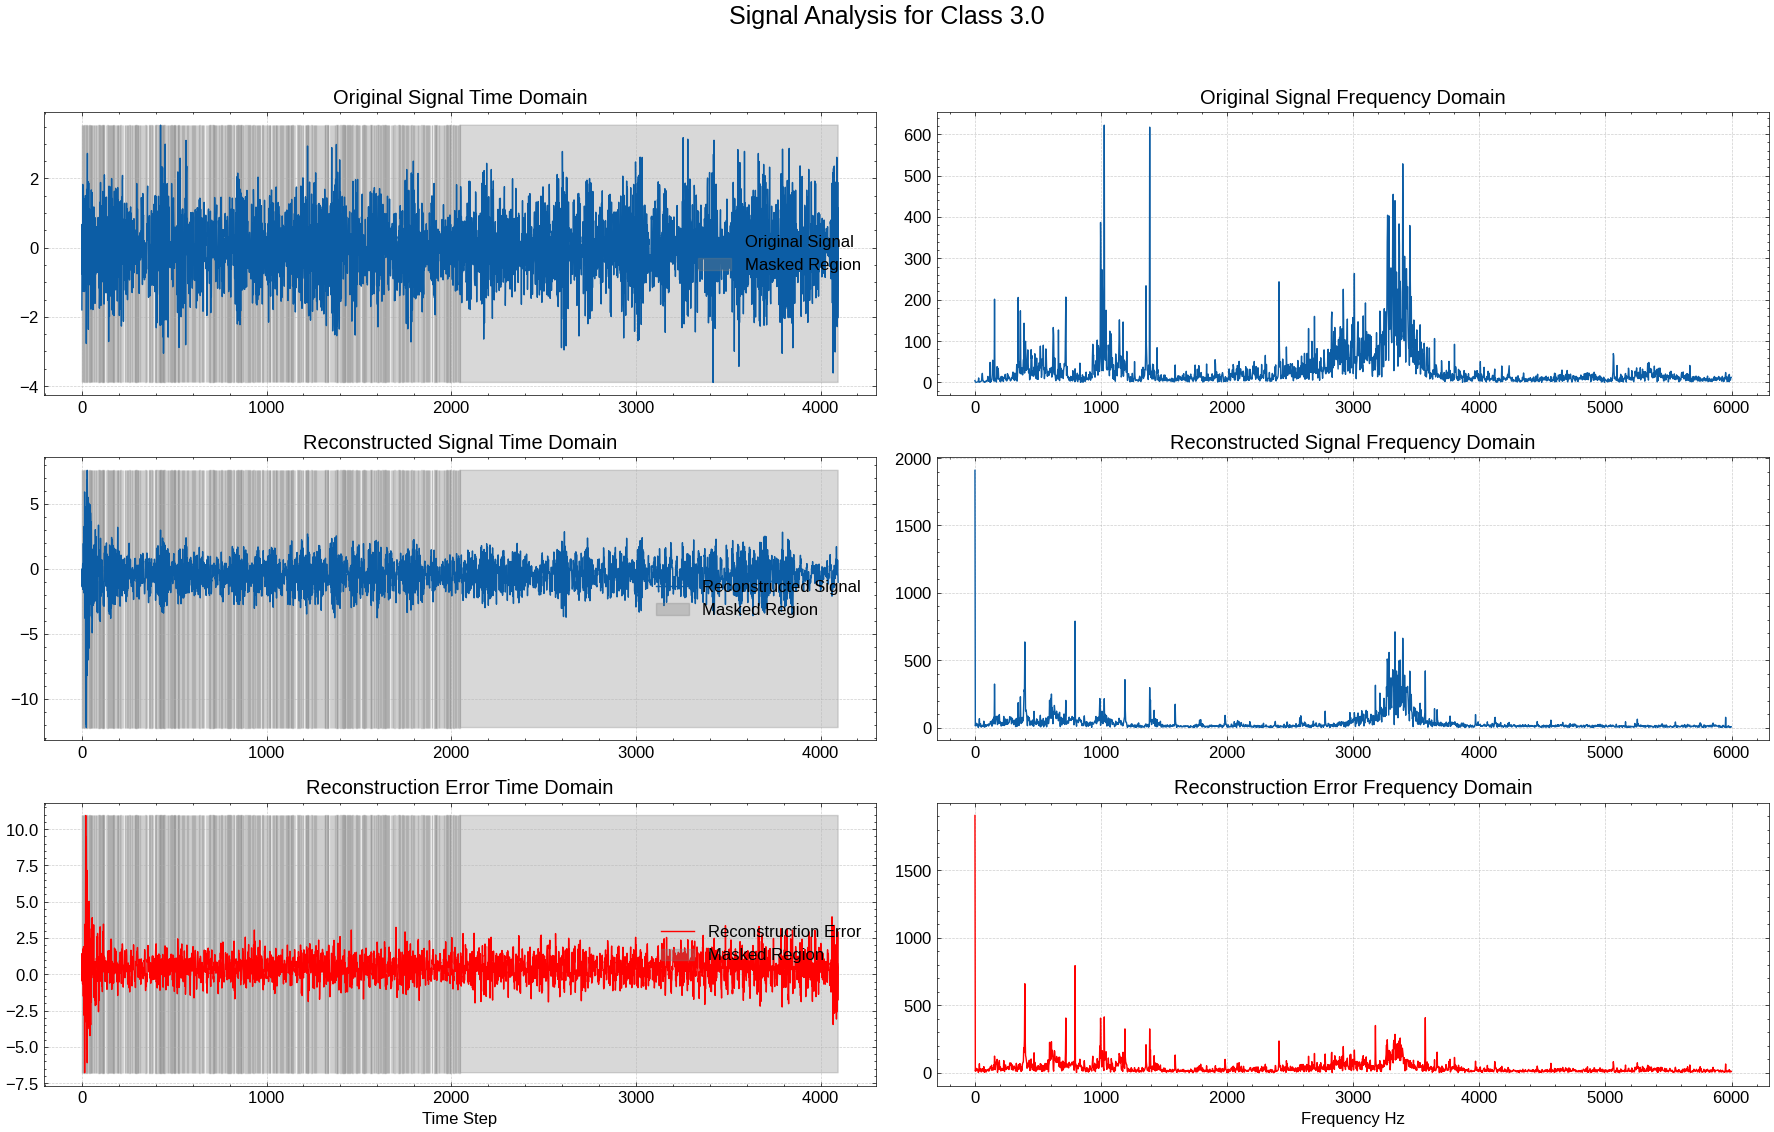

In [14]:
import numpy.fft as fft
from src.utils.masking import add_mask
for label, (original_tensor, reconstructed, error) in samples_to_plot.items():
    _ , mask = add_mask(original_tensor, args_task.forecast_part, args_task.mask_ratio)
    original = original_tensor.squeeze().cpu().numpy()
    
    # If the signal is multi-channel, plot only the first channel
    if original.ndim > 1:
        original = original[:,0]
        reconstructed = reconstructed[:,0]
        error = error[:,0]
        mask = mask[0,:,0].cpu().numpy() if mask is not None else None
    timesteps = np.arange(len(original))

    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    fig.suptitle(f'Signal Analysis for Class {label}', fontsize=18)

    # --- Column 1: Time Domain Plots ---
    # Plot Original Signal with mask
    axes[0, 0].plot(timesteps, original, label='Original Signal')
    if mask is not None:
        axes[0, 0].fill_between(
            timesteps,
            original.min(),
            original.max(),
            where=mask,
            color='gray',
            alpha=0.3,
            label='Masked Region'
        )
    axes[0, 0].set_title('Original Signal Time Domain')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # Plot Reconstructed Signal with mask
    axes[1, 0].plot(timesteps, reconstructed, label='Reconstructed Signal')
    if mask is not None:
        axes[1, 0].fill_between(
            timesteps,
            reconstructed.min(),
            reconstructed.max(),
            where=mask,
            color='gray',
            alpha=0.3,
            label='Masked Region'
        )
    axes[1, 0].set_title('Reconstructed Signal Time Domain')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # Plot Reconstruction Error with mask
    axes[2, 0].plot(timesteps, error, color='red', label='Reconstruction Error')
    if mask is not None:
        axes[2, 0].fill_between(
            timesteps,
            error.min(),
            error.max(),
            where=mask,
            color='gray',
            alpha=0.3,
            label='Masked Region'
        )
    axes[2, 0].set_title('Reconstruction Error Time Domain')
    axes[2, 0].set_xlabel('Time Step')
    axes[2, 0].legend()
    axes[2, 0].grid(True, linestyle='--', alpha=0.6)

    # --- Column 2: Frequency Domain (FFT) Plots ---
    # !!! IMPORTANT: Set the correct sampling frequency for your dataset !!!
    # CWRU is often 12000 Hz or 48000 Hz.
    fs = 12000  # Sampling Frequency in Hz
    n = len(original)  # Signal length
    print(f"Signal length: {n}, Sampling Frequency: {fs} Hz")
    # Calculate frequency axis
    freq_axis = fft.fftfreq(n, d=1/fs)[:n//2]
    
    # Calculate FFT and magnitude
    original_fft = np.abs(fft.fft(original))[:n//2]
    reconstructed_fft = np.abs(fft.fft(reconstructed))[:n//2]
    error_fft = np.abs(fft.fft(error))[:n//2]

    # Plot Original Signal Spectrum
    axes[0, 1].plot(freq_axis, original_fft)
    axes[0, 1].set_title('Original Signal Frequency Domain')
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # Plot Reconstructed Signal Spectrum
    axes[1, 1].plot(freq_axis, reconstructed_fft)
    axes[1, 1].set_title('Reconstructed Signal Frequency Domain')
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    # Plot Error Spectrum
    axes[2, 1].plot(freq_axis, error_fft, color='red')
    axes[2, 1].set_title('Reconstruction Error Frequency Domain')
    axes[2, 1].set_xlabel('Frequency Hz')
    axes[2, 1].grid(True, linestyle='--', alpha=0.6)

    # --- Save and Show Plot ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    # Save the figure
    save_dir = 'save/reconstruction_fft'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(f'{save_dir}/masked100_{label}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{save_dir}/masked100_{label}.pdf', bbox_inches='tight')

    plt.show()

#### hidden umap

In [17]:
num = 10
all_embeddings = []
all_labels = []
all_file_ids = []

for batch in tqdm(test_data_loader, desc="提取表征中"):
    y = batch['y'][:num]  # 只取前 num 个样本
    x = batch['x'].to(device)[:num]  # 只取前 num 个样本
    file_id = batch['file_id'][:num] if 'file_id' in batch else None        
    reps = model_masked_prediction.get_rep(x, file_id=file_id) 
    all_embeddings.append(reps.cpu().detach().numpy())
    all_labels.append(y.cpu().detach().numpy())
    if file_id is not None:
        # file_id 可能是字符串或数字，需转为numpy数组
        if isinstance(file_id, torch.Tensor):
            all_file_ids.append(file_id.cpu().detach().numpy())
        else:
            all_file_ids.append(np.array(file_id))
    else:
        all_file_ids.append(np.array(['unknown'] * len(y)))

提取表征中:   0%|          | 0/148 [00:00<?, ?it/s]

提取表征中: 100%|██████████| 148/148 [00:00<00:00, 253.40it/s]



UMAP 降维中，样本总数: 1480...


/home/lq/.conda/envs/P/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lq/.conda/envs/P/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


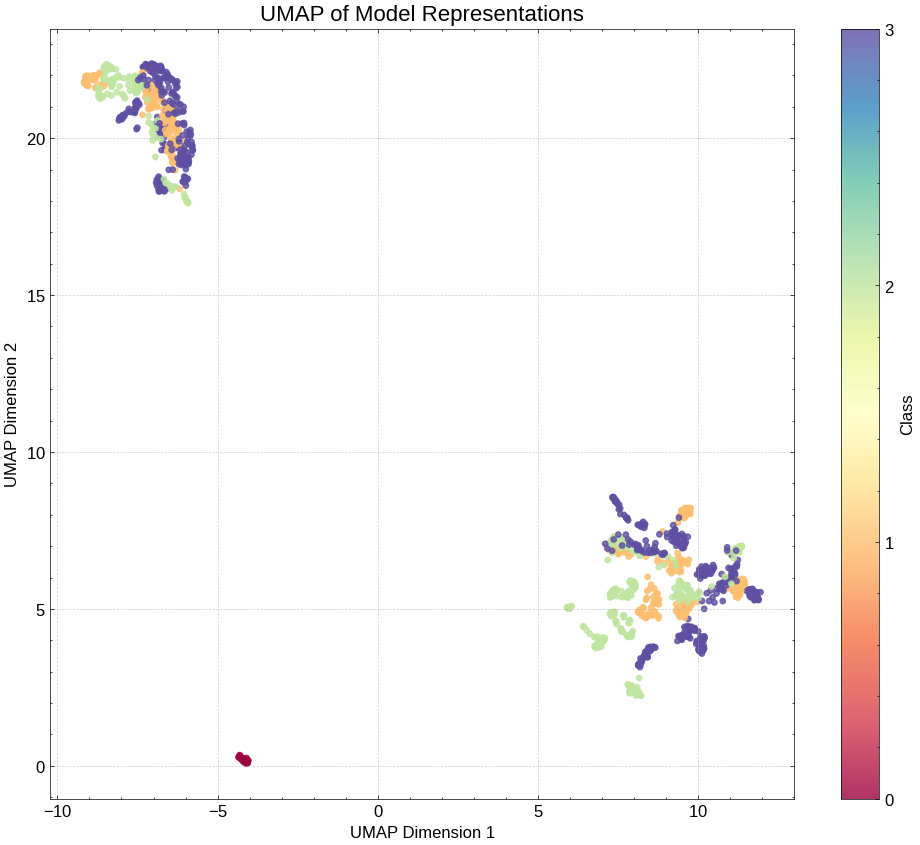

In [20]:
# --- 3. UMAP 可视化 (后续代码不变) ---
import umap
all_reps = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_file_ids = np.concatenate(all_file_ids, axis=0)


all_reps = all_reps.reshape(all_reps.shape[0], -1)  # 确保是二维数组

print(f"\nUMAP 降维中，样本总数: {all_reps.shape[0]}...")
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(all_reps)

np.save('save/masked_hidden_embedding_2d_100.npy', embedding_2d, allow_pickle=True)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=all_labels,
    cmap='Spectral',
    s=15,
    alpha=0.8
)
cbar = plt.colorbar(scatter, ticks=np.unique(all_labels))
cbar.set_label('Class')
plt.title('UMAP of Model Representations', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True, linestyle='--', alpha=0.6)

save_dir = 'save/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(f'{save_dir}/umap_masked_rep100.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{save_dir}/umap_masked_rep100.pdf', bbox_inches='tight')

plt.show()

In [ ]:
df = pd.DataFrame(embedding_2d, columns=['umap_x', 'umap_y'])
df['label'] = all_labels
df['file_id'] = all_file_ids
csv_path = 'save/umap_2d_with_label100.csv'
df.to_csv(csv_path, index=False)
print(f"已保存到 {csv_path}")

已保存到 save/umap_2d_with_label.csv


## zero-shot umap

In [21]:
import numpy as np
import torch
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import umap
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_features(dataloader, model=None, use_rep=False):
    """提取特征和标签，use_rep=True时用模型的get_rep，否则用原始信号"""
    features = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            x = batch['x'].to(device)
            y = batch['y']
            if use_rep and model is not None:
                file_id = batch['file_id'] if 'file_id' in batch else None
                rep = model.get_rep(x, file_id=file_id)
                rep = rep.cpu().numpy()
                rep = rep.reshape(rep.shape[0], -1)
                features.append(rep)
            else:
                # 原始信号直接展平
                x_np = x.cpu().numpy()
                x_np = x_np.reshape(x_np.shape[0], -1)
                features.append(x_np)
            labels.append(y.cpu().numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# ----------- 1. 提取并保存所有特征 -----------
print("提取并保存所有特征...")

# 原始信号
X_train, y_train = extract_features(train_data_loader, use_rep=False)
X_test, y_test = extract_features(test_data_loader, use_rep=False)

# umap模型
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
X_all = np.concatenate((X_train, X_test), axis=0)
X_all_2d = reducer.fit_transform(X_all.reshape(X_all.shape[0], -1))
X_train = X_all_2d[:len(X_train)]
X_test = X_all_2d[len(X_train):]

# mse模型
mse_model = build_model(args_model, metadata=data_factory.get_metadata())
mse_model.load_state_dict(torch.load('save/mse_model_prediction.pth', map_location=device))
mse_model.to(device)
mse_model.eval()
X_train2, y_train2 = extract_features(train_data_loader, model=mse_model, use_rep=True)
X_test2, y_test2 = extract_features(test_data_loader, model=mse_model, use_rep=True)

reduce = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
X_all2 = np.concatenate((X_train2, X_test2), axis=0)
X_all2_2d = reduce.fit_transform(X_all2.reshape(X_all2.shape[0], -1))
X_train2 = X_all2_2d[:len(X_train2)]
X_test2 = X_all2_2d[len(X_train2):]

# masked模型
masked_model = build_model(args_model, metadata=data_factory.get_metadata())
masked_model.load_state_dict(torch.load('save/masked_prediction_model_prediction_100epoch.pth', map_location=device))
masked_model.to(device)
masked_model.eval()
X_train3, y_train3 = extract_features(train_data_loader, model=masked_model, use_rep=True)
X_test3, y_test3 = extract_features(test_data_loader, model=masked_model, use_rep=True)

# 使用 UMAP 降维
reduce = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
X_all3 = np.concatenate((X_train3, X_test3), axis=0)
X_all3_2d = reduce.fit_transform(X_all3.reshape(X_all3.shape[0], -1))
X_train3 = X_all3_2d[:len(X_train3)]
X_test3 = X_all3_2d[len(X_train3):]

# 保存
np.savez('save/zero_shot_svm_features.npz',
         X_train=X_train, y_train=y_train,
         X_train2=X_train2, y_train2=y_train2,
         X_train3=X_train3, y_train3=y_train3,
         X_test=X_test, y_test=y_test,
         X_test2=X_test2, y_test2=y_test2,
         X_test3=X_test3, y_test3=y_test3)
print("特征已保存。")



提取并保存所有特征...


  0%|          | 0/360 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 378.20it/s]
/home/lq/.conda/envs/P/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lq/.conda/envs/P/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


成功导入模型模块: M_02_ISFM


100%|██████████| 148/148 [00:01<00:00, 114.83it/s]
/home/lq/.conda/envs/P/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lq/.conda/envs/P/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


成功导入模型模块: M_02_ISFM


100%|██████████| 148/148 [00:01<00:00, 114.83it/s]
/home/lq/.conda/envs/P/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lq/.conda/envs/P/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


特征已保存。


In [22]:
# ----------- 2. 加载特征并训练SVM -----------
print("加载特征并训练SVM...")

data = np.load('save/zero_shot_svm_features.npz')

# case 1: 原始信号
print("Case 1: 原始信号 SVM")
clf1 = SVC(max_iter=1000, verbose=True)
clf1.fit(data['X_train'], data['y_train'])
y_pred1 = clf1.predict(data['X_test'])
acc1 = accuracy_score(data['y_test'], y_pred1)
print(f"Case 1 原始信号 SVM 测试准确率: {acc1:.4f}")

# case 2: mse model
print("Case 2: MSE模型特征 SVM")
clf2 = SVC(max_iter=1000, verbose=True)
clf2.fit(data['X_train2'], data['y_train2'])
y_pred2 = clf2.predict(data['X_test2'])
acc2 = accuracy_score(data['y_test2'], y_pred2)
print(f"Case 2 MSE模型特征 SVM 测试准确率: {acc2:.4f}")

# case 3: masked model
print("Case 3: Masked模型特征 SVM")
clf3 = SVC(max_iter=1000, verbose=True)
clf3.fit(data['X_train3'], data['y_train3'])
y_pred3 = clf3.predict(data['X_test3'])
acc3 = accuracy_score(data['y_test3'], y_pred3)
print(f"Case 3 Masked模型特征 SVM 测试准确率: {acc3:.4f}")

加载特征并训练SVM...
Case 1: 原始信号 SVM
[LibSVM]*
optimization finished, #iter = 242
obj = -234.490127, rho = 8.300808
nSV = 326, nBSV = 320
*
optimization finished, #iter = 352
obj = -453.861365, rho = 9.962148
nSV = 597, nBSV = 593
*
optimization finished, #iter = 453
obj = -463.239766, rho = 12.290531
nSV = 645, nBSV = 640
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.892956, rho = -0.135386
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.936951, rho = -0.106769
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.919889, rho = -0.076559
nSV = 2000, nBSV = 2000
Total nSV = 6703


/home/lq/.conda/envs/P/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Case 1 原始信号 SVM 测试准确率: 0.2953
Case 2: MSE模型特征 SVM
[LibSVM]*
optimization finished, #iter = 476
obj = -669.632465, rho = 10.748051
nSV = 877, nBSV = 873
*
optimization finished, #iter = 678
obj = -1080.371480, rho = 8.778416
nSV = 1225, nBSV = 1222
*
optimization finished, #iter = 653
obj = -963.808996, rho = 12.073730
nSV = 1203, nBSV = 1199
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.935968, rho = -0.108216
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.977303, rho = -0.073666
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1999.976676, rho = -0.060528
nSV = 2000, nBSV = 2000
Total nSV = 7248


/home/lq/.conda/envs/P/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Case 2 MSE模型特征 SVM 测试准确率: 0.1201
Case 3: Masked模型特征 SVM
[LibSVM]*
optimization finished, #iter = 19
obj = -1.848286, rho = 0.605214
nSV = 9, nBSV = 1
*
optimization finished, #iter = 20
obj = -1.796819, rho = 0.569959
nSV = 8, nBSV = 1
*
optimization finished, #iter = 21
obj = -2.432044, rho = 0.617075
nSV = 9, nBSV = 3
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1819.971410, rho = 0.303759
nSV = 1994, nBSV = 1994
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1971.546278, rho = -2.088852
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1986.405114, rho = 0.152413
nSV = 2000, nBSV = 2000
Total nSV = 4518


/home/lq/.conda/envs/P/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Case 3 Masked模型特征 SVM 测试准确率: 0.3123


### 2

# 2 cross-dataset representation

## 0 prepare

### 1 dataset

In [35]:
# 解析命令行参数
parser = argparse.ArgumentParser(description="实验流水线")

parser.add_argument('--config_path', 
                    type=str, 
                    default='/home/lq/LQcode/2_project/PHMBench/PHM-Vibench/configs/dev/exp1_mse_lossforgeneration.yaml',
                    help='配置文件路径')
parser.add_argument('--notes', 
                    type=str, 
                    default='exp1_mse_vs_flow',
                    help='实验备注')

# 在Jupyter环境中，使用默认参数或手动设置
# args = parser.parse_args()
args = parser.parse_args(args=[]) # 使用默认值

# 执行流水线
"""
实验流水线，负责加载配置、数据和模型。
"""
# -----------------------
# 1. 加载配置文件
# -----------------------
config_path = args.config_path
print(f"[INFO] 加载配置文件: {config_path}")
configs = load_config(config_path)


# 设置环境变量和命名空间
args_environment = transfer_namespace(configs.get('environment', {}))
args_data = transfer_namespace(configs.get('data', {}))
args_model = transfer_namespace(configs.get('model', {}))
args_task = transfer_namespace(configs.get('task', {}))



# -----------------------
# 2. 准备实验环境和数据
# -----------------------
# 仅使用第一次迭代进行设置
it = 0
print(f"\n{'='*50}\n[INFO] 准备实验环境 (基于迭代 {it+1})\n{'='*50}")

# 设置路径和名称
path, name = path_name(configs, it)

# 设置随机种子
current_seed = args_environment.seed + it
seed_everything(current_seed)
print(f"[INFO] 设置随机种子: {current_seed}")

# 初始化 wandb/swanlab
# init_lab(args_environment, args, name)


    

Seed set to 42


[INFO] 加载配置文件: /home/lq/LQcode/2_project/PHMBench/PHM-Vibench/configs/dev/exp1_mse_lossforgeneration.yaml
/home/lq/LQcode/2_project/PHMBench/PHM-Vibench/dev/preexp

[INFO] 准备实验环境 (基于迭代 1)
[INFO] 设置随机种子: 42


In [36]:
# 构建数据工厂
print("[INFO] 构建数据工厂...")
data_factory = build_data(args_data, args_task)

[INFO] 构建数据工厂...
[INFO] 检查缓存文件: 数据文件已存在: /mnt/crucial/LQ/PHM-Vibench/metadata_6_11.xlsx 
[SUCCESS] 成功加载元数据，共 49867 条记录
筛选前元数据行数: 49867
筛选后元数据行数: 234
检查并准备各 Name.h5 缓存文件...


检查 Name.h5 缓存: 100%|██████████| 234/234 [00:00<00:00, 5212.50it/s]


正在将数据整合到任务缓存文件: /mnt/crucial/LQ/PHM-Vibench/cache.h5 ...


检查 cache.h5 是否已存在: 100%|██████████| 234/234 [00:00<00:00, 145812.98it/s]


数据整合完成。最终缓存文件: /mnt/crucial/LQ/PHM-Vibench/cache.h5
Using default task.
CDGD划分 - 选择每个数据集的最后1个domain作为测试集
数据集 1:
  - 训练域: [np.float64(0.0), np.float64(1.0), np.float64(2.0)]
  - 测试域: [np.float64(3.0)]
数据集 5:
  - 训练域: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0)]
  - 测试域: [np.float64(27.0)]
数据集 6:
  - 训练域: [np.float64(0.0), np.float64(1.0)]
  - 测试域: [np.float64(2.0)]
训练/验证样本数: 188
测试样本数: 46
Initializing training and validation datasets...


Creating train/val datasets: 100%|██████████| 188/188 [00:06<00:00, 28.88it/s]


Initializing test datasets...


Creating test datasets: 100%|██████████| 46/46 [00:00<00:00, 65.84it/s]


## 1 pretraining

In [37]:
train_data_loader = data_factory.get_dataloader('train')
val_data_loader = data_factory.get_dataloader('val')
test_data_loader = data_factory.get_dataloader('test')

In [31]:
train_data_loader.dataset

In [38]:
len(train_data_loader.dataset)

38352

### init model

In [39]:
from src.task_factory.Components.prediction_loss import Signal_mask_Loss
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# 指定显卡
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args_model
# 构建模型
model = build_model(args_model, metadata=data_factory.get_metadata())
model.to(device)



成功导入模型模块: M_02_ISFM


Model(
  (embedding): E_02_HSE_v2(
    (patcher): SequencePatcher()
    (channel_embedders): ModuleDict(
      (1): Sequential(
        (0): Linear(in_features=3, out_features=16, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=16, out_features=8, bias=True)
      )
      (5): Sequential(
        (0): Linear(in_features=4, out_features=16, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=16, out_features=8, bias=True)
      )
      (6): Sequential(
        (0): Linear(in_features=2, out_features=16, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=16, out_features=8, bias=True)
      )
    )
    (proj_patch): Linear(in_features=2048, out_features=64, bias=True)
  )
  (backbone): B_10_VIBT(
    (blocks): ModuleList(
      (0): ViBTBlock(
        (norm1): RMSNorm()
        (attn): Attention(
          (qkv): Linear(in_features=64, out_features=192, bias=True)
          (q_norm): RMSNorm()
   

In [48]:
# 损失和优化器
criterion = Signal_mask_Loss(args_task)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 100

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        batch['x'] = batch['x'].to(device)
        optimizer.zero_grad()
        loss = criterion(model, batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Epoch {epoch+1} 完成. 平均损失: {epoch_loss:.6f}")

print("--- 训练完成 ---")

Epoch 1/100: 100%|██████████| 599/599 [00:15<00:00, 37.67it/s]


Epoch 1 完成. 平均损失: 0.907385


Epoch 2/100: 100%|██████████| 599/599 [00:15<00:00, 38.28it/s]


Epoch 2 完成. 平均损失: 0.837755


Epoch 3/100: 100%|██████████| 599/599 [00:15<00:00, 38.05it/s]


Epoch 3 完成. 平均损失: 0.815255


Epoch 4/100: 100%|██████████| 599/599 [00:16<00:00, 36.98it/s]


Epoch 4 完成. 平均损失: 0.800685


Epoch 5/100: 100%|██████████| 599/599 [00:15<00:00, 38.29it/s]


Epoch 5 完成. 平均损失: 0.791799


Epoch 6/100: 100%|██████████| 599/599 [00:15<00:00, 37.60it/s]


Epoch 6 完成. 平均损失: 0.785751


Epoch 7/100: 100%|██████████| 599/599 [00:15<00:00, 37.45it/s]


Epoch 7 完成. 平均损失: 0.781575


Epoch 8/100: 100%|██████████| 599/599 [00:15<00:00, 37.49it/s]


Epoch 8 完成. 平均损失: 0.776726


Epoch 9/100: 100%|██████████| 599/599 [00:15<00:00, 37.73it/s]


Epoch 9 完成. 平均损失: 0.772963


Epoch 10/100: 100%|██████████| 599/599 [00:15<00:00, 38.17it/s]


Epoch 10 完成. 平均损失: 0.769384


Epoch 11/100: 100%|██████████| 599/599 [00:16<00:00, 37.33it/s]


Epoch 11 完成. 平均损失: 0.765281


Epoch 12/100: 100%|██████████| 599/599 [00:16<00:00, 37.37it/s]


Epoch 12 完成. 平均损失: 0.765493


Epoch 13/100: 100%|██████████| 599/599 [00:15<00:00, 38.35it/s]


Epoch 13 完成. 平均损失: 0.761469


Epoch 14/100: 100%|██████████| 599/599 [00:15<00:00, 37.66it/s]


Epoch 14 完成. 平均损失: 0.760022


Epoch 15/100: 100%|██████████| 599/599 [00:15<00:00, 37.48it/s]


Epoch 15 完成. 平均损失: 0.758545


Epoch 16/100: 100%|██████████| 599/599 [00:15<00:00, 38.26it/s]


Epoch 16 完成. 平均损失: 0.756481


Epoch 17/100: 100%|██████████| 599/599 [00:15<00:00, 37.82it/s]


Epoch 17 完成. 平均损失: 0.754615


Epoch 18/100: 100%|██████████| 599/599 [00:15<00:00, 38.44it/s]


Epoch 18 完成. 平均损失: 0.753367


Epoch 19/100: 100%|██████████| 599/599 [00:15<00:00, 38.03it/s]


Epoch 19 完成. 平均损失: 0.751110


Epoch 20/100: 100%|██████████| 599/599 [00:15<00:00, 38.77it/s]


Epoch 20 完成. 平均损失: 0.751533


Epoch 21/100: 100%|██████████| 599/599 [00:15<00:00, 37.65it/s]


Epoch 21 完成. 平均损失: 0.748713


Epoch 22/100: 100%|██████████| 599/599 [00:15<00:00, 38.55it/s]


Epoch 22 完成. 平均损失: 0.749109


Epoch 23/100: 100%|██████████| 599/599 [00:16<00:00, 37.38it/s]


Epoch 23 完成. 平均损失: 0.748025


Epoch 24/100: 100%|██████████| 599/599 [00:16<00:00, 37.40it/s]


Epoch 24 完成. 平均损失: 0.744979


Epoch 25/100: 100%|██████████| 599/599 [00:16<00:00, 37.29it/s]


Epoch 25 完成. 平均损失: 0.743595


Epoch 26/100: 100%|██████████| 599/599 [00:15<00:00, 38.01it/s]


Epoch 26 完成. 平均损失: 0.742980


Epoch 27/100: 100%|██████████| 599/599 [00:16<00:00, 37.11it/s]


Epoch 27 完成. 平均损失: 0.742908


Epoch 28/100: 100%|██████████| 599/599 [00:15<00:00, 38.49it/s]


Epoch 28 完成. 平均损失: 0.742025


Epoch 29/100: 100%|██████████| 599/599 [00:16<00:00, 37.41it/s]


Epoch 29 完成. 平均损失: 0.740066


Epoch 30/100: 100%|██████████| 599/599 [00:15<00:00, 37.83it/s]


Epoch 30 完成. 平均损失: 0.739507


Epoch 31/100: 100%|██████████| 599/599 [00:15<00:00, 37.64it/s]


Epoch 31 完成. 平均损失: 0.738359


Epoch 32/100: 100%|██████████| 599/599 [00:15<00:00, 37.70it/s]


Epoch 32 完成. 平均损失: 0.739108


Epoch 33/100: 100%|██████████| 599/599 [00:16<00:00, 37.00it/s]


Epoch 33 完成. 平均损失: 0.736302


Epoch 34/100: 100%|██████████| 599/599 [00:15<00:00, 37.76it/s]


Epoch 34 完成. 平均损失: 0.737205


Epoch 35/100: 100%|██████████| 599/599 [00:15<00:00, 37.61it/s]


Epoch 35 完成. 平均损失: 0.735412


Epoch 36/100: 100%|██████████| 599/599 [00:16<00:00, 37.42it/s]


Epoch 36 完成. 平均损失: 0.735465


Epoch 37/100: 100%|██████████| 599/599 [00:15<00:00, 37.86it/s]


Epoch 37 完成. 平均损失: 0.735652


Epoch 38/100: 100%|██████████| 599/599 [00:16<00:00, 36.67it/s]


Epoch 38 完成. 平均损失: 0.733637


Epoch 39/100: 100%|██████████| 599/599 [00:16<00:00, 37.15it/s]


Epoch 39 完成. 平均损失: 0.735215


Epoch 40/100: 100%|██████████| 599/599 [00:15<00:00, 37.78it/s]


Epoch 40 完成. 平均损失: 0.733949


Epoch 41/100: 100%|██████████| 599/599 [00:15<00:00, 37.57it/s]


Epoch 41 完成. 平均损失: 0.732126


Epoch 42/100: 100%|██████████| 599/599 [00:16<00:00, 36.27it/s]


Epoch 42 完成. 平均损失: 0.731536


Epoch 43/100: 100%|██████████| 599/599 [00:15<00:00, 38.03it/s]


Epoch 43 完成. 平均损失: 0.730884


Epoch 44/100: 100%|██████████| 599/599 [00:15<00:00, 38.10it/s]


Epoch 44 完成. 平均损失: 0.730447


Epoch 45/100: 100%|██████████| 599/599 [00:16<00:00, 37.27it/s]


Epoch 45 完成. 平均损失: 0.731123


Epoch 46/100: 100%|██████████| 599/599 [00:15<00:00, 37.88it/s]


Epoch 46 完成. 平均损失: 0.730840


Epoch 47/100: 100%|██████████| 599/599 [00:16<00:00, 37.42it/s]


Epoch 47 完成. 平均损失: 0.729929


Epoch 48/100: 100%|██████████| 599/599 [00:16<00:00, 35.39it/s]


Epoch 48 完成. 平均损失: 0.729461


Epoch 49/100: 100%|██████████| 599/599 [00:16<00:00, 36.29it/s]


Epoch 49 完成. 平均损失: 0.729519


Epoch 50/100: 100%|██████████| 599/599 [00:16<00:00, 37.31it/s]


Epoch 50 完成. 平均损失: 0.728909


Epoch 51/100: 100%|██████████| 599/599 [00:15<00:00, 37.57it/s]


Epoch 51 完成. 平均损失: 0.727200


Epoch 52/100: 100%|██████████| 599/599 [00:15<00:00, 38.10it/s]


Epoch 52 完成. 平均损失: 0.726989


Epoch 53/100: 100%|██████████| 599/599 [00:16<00:00, 37.13it/s]


Epoch 53 完成. 平均损失: 0.726291


Epoch 54/100: 100%|██████████| 599/599 [00:16<00:00, 37.09it/s]


Epoch 54 完成. 平均损失: 0.729436


Epoch 55/100: 100%|██████████| 599/599 [00:15<00:00, 37.50it/s]


Epoch 55 完成. 平均损失: 0.726929


Epoch 56/100: 100%|██████████| 599/599 [00:16<00:00, 37.36it/s]


Epoch 56 完成. 平均损失: 0.726814


Epoch 57/100: 100%|██████████| 599/599 [00:15<00:00, 37.56it/s]


Epoch 57 完成. 平均损失: 0.726231


Epoch 58/100: 100%|██████████| 599/599 [00:15<00:00, 38.06it/s]


Epoch 58 完成. 平均损失: 0.726734


Epoch 59/100: 100%|██████████| 599/599 [00:15<00:00, 37.78it/s]


Epoch 59 完成. 平均损失: 0.725987


Epoch 60/100: 100%|██████████| 599/599 [00:15<00:00, 38.78it/s]


Epoch 60 完成. 平均损失: 0.724393


Epoch 61/100: 100%|██████████| 599/599 [00:16<00:00, 36.08it/s]


Epoch 61 完成. 平均损失: 0.724287


Epoch 62/100: 100%|██████████| 599/599 [00:16<00:00, 37.35it/s]


Epoch 62 完成. 平均损失: 0.724103


Epoch 63/100: 100%|██████████| 599/599 [00:16<00:00, 37.01it/s]


Epoch 63 完成. 平均损失: 0.724109


Epoch 64/100: 100%|██████████| 599/599 [00:15<00:00, 37.71it/s]


Epoch 64 完成. 平均损失: 0.723167


Epoch 65/100: 100%|██████████| 599/599 [00:15<00:00, 37.44it/s]


Epoch 65 完成. 平均损失: 0.724865


Epoch 66/100: 100%|██████████| 599/599 [00:15<00:00, 37.64it/s]


Epoch 66 完成. 平均损失: 0.723190


Epoch 67/100: 100%|██████████| 599/599 [00:15<00:00, 38.05it/s]


Epoch 67 完成. 平均损失: 0.724028


Epoch 68/100: 100%|██████████| 599/599 [00:15<00:00, 38.03it/s]


Epoch 68 完成. 平均损失: 0.724001


Epoch 69/100: 100%|██████████| 599/599 [00:15<00:00, 38.37it/s]


Epoch 69 完成. 平均损失: 0.723545


Epoch 70/100: 100%|██████████| 599/599 [00:15<00:00, 38.20it/s]


Epoch 70 完成. 平均损失: 0.723590


Epoch 71/100: 100%|██████████| 599/599 [00:15<00:00, 37.88it/s]


Epoch 71 完成. 平均损失: 0.723463


Epoch 72/100: 100%|██████████| 599/599 [00:16<00:00, 37.13it/s]


Epoch 72 完成. 平均损失: 0.723167


Epoch 73/100: 100%|██████████| 599/599 [00:15<00:00, 38.21it/s]


Epoch 73 完成. 平均损失: 0.722595


Epoch 74/100: 100%|██████████| 599/599 [00:15<00:00, 37.51it/s]


Epoch 74 完成. 平均损失: 0.723185


Epoch 75/100: 100%|██████████| 599/599 [00:15<00:00, 38.26it/s]


Epoch 75 完成. 平均损失: 0.722975


Epoch 76/100: 100%|██████████| 599/599 [00:15<00:00, 37.51it/s]


Epoch 76 完成. 平均损失: 0.721413


Epoch 77/100: 100%|██████████| 599/599 [00:15<00:00, 37.99it/s]


Epoch 77 完成. 平均损失: 0.720763


Epoch 78/100: 100%|██████████| 599/599 [00:15<00:00, 37.48it/s]


Epoch 78 完成. 平均损失: 0.720754


Epoch 79/100: 100%|██████████| 599/599 [00:16<00:00, 36.78it/s]


Epoch 79 完成. 平均损失: 0.721797


Epoch 80/100: 100%|██████████| 599/599 [00:15<00:00, 38.28it/s]


Epoch 80 完成. 平均损失: 0.721499


Epoch 81/100: 100%|██████████| 599/599 [00:15<00:00, 37.45it/s]


Epoch 81 完成. 平均损失: 0.720577


Epoch 82/100: 100%|██████████| 599/599 [00:15<00:00, 38.08it/s]


Epoch 82 完成. 平均损失: 0.720409


Epoch 83/100: 100%|██████████| 599/599 [00:15<00:00, 38.50it/s]


Epoch 83 完成. 平均损失: 0.720130


Epoch 84/100: 100%|██████████| 599/599 [00:16<00:00, 37.25it/s]


Epoch 84 完成. 平均损失: 0.719923


Epoch 85/100: 100%|██████████| 599/599 [00:15<00:00, 37.61it/s]


Epoch 85 完成. 平均损失: 0.721050


Epoch 86/100: 100%|██████████| 599/599 [00:15<00:00, 38.30it/s]


Epoch 86 完成. 平均损失: 0.720112


Epoch 87/100: 100%|██████████| 599/599 [00:15<00:00, 37.61it/s]


Epoch 87 完成. 平均损失: 0.720362


Epoch 88/100: 100%|██████████| 599/599 [00:15<00:00, 37.73it/s]


Epoch 88 完成. 平均损失: 0.720767


Epoch 89/100: 100%|██████████| 599/599 [00:16<00:00, 37.43it/s]


Epoch 89 完成. 平均损失: 0.720317


Epoch 90/100: 100%|██████████| 599/599 [00:15<00:00, 38.05it/s]


Epoch 90 完成. 平均损失: 0.719139


Epoch 91/100: 100%|██████████| 599/599 [00:15<00:00, 37.96it/s]


Epoch 91 完成. 平均损失: 0.720435


Epoch 92/100: 100%|██████████| 599/599 [00:15<00:00, 37.62it/s]


Epoch 92 完成. 平均损失: 0.720126


Epoch 93/100: 100%|██████████| 599/599 [00:16<00:00, 36.83it/s]


Epoch 93 完成. 平均损失: 0.718625


Epoch 94/100: 100%|██████████| 599/599 [00:15<00:00, 37.94it/s]


Epoch 94 完成. 平均损失: 0.719991


Epoch 95/100: 100%|██████████| 599/599 [00:15<00:00, 38.37it/s]


Epoch 95 完成. 平均损失: 0.719785


Epoch 96/100: 100%|██████████| 599/599 [00:15<00:00, 37.79it/s]


Epoch 96 完成. 平均损失: 0.718440


Epoch 97/100: 100%|██████████| 599/599 [00:15<00:00, 37.71it/s]


Epoch 97 完成. 平均损失: 0.719511


Epoch 98/100: 100%|██████████| 599/599 [00:15<00:00, 38.15it/s]


Epoch 98 完成. 平均损失: 0.719164


Epoch 99/100: 100%|██████████| 599/599 [00:16<00:00, 37.34it/s]


Epoch 99 完成. 平均损失: 0.718112


Epoch 100/100: 100%|██████████| 599/599 [00:16<00:00, 37.30it/s]

Epoch 100 完成. 平均损失: 0.718514
--- 训练完成 ---


# 3 contrastive circle flow